In [ ]:
!pip install pyspark

# Load thư viện pyspark

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Init SparkSession
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()


# Đọc dữ liệu

In [ ]:
df = spark.read.csv("weather_dataset.csv", header=True, inferSchema=True)

In [ ]:
df.show(5)

+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country| lat|     lon|           tz_id|          localtime|      date|               time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+------

In [ ]:
df.createOrReplaceTempView("weather_dataset")

# Kiểm tra null

In [ ]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------------+-------+---+---+-----+---------+----+----+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country|lat|lon|tz_id|localtime|date|time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+---+---+-----+---------+----+----+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+--

# Kiểm tra unique

In [ ]:
from pyspark.sql.functions import countDistinct

for col_name in df.columns:
    unique_count = df.select(countDistinct(col_name)).collect()[0][0]
    print(f"Column '{col_name}' has {unique_count} unique values.")


Column 'location_name' has 63 unique values.
Column 'country' has 1 unique values.
Column 'lat' has 62 unique values.
Column 'lon' has 62 unique values.
Column 'tz_id' has 2 unique values.
Column 'localtime' has 255 unique values.
Column 'date' has 367 unique values.
Column 'time' has 8808 unique values.
Column 'temp_c' has 425 unique values.
Column 'temp_f' has 740 unique values.
Column 'is_day' has 2 unique values.
Column 'condition_text' has 21 unique values.
Column 'wind_mph' has 310 unique values.
Column 'wind_kph' has 456 unique values.
Column 'wind_degree' has 361 unique values.
Column 'wind_dir' has 16 unique values.
Column 'pressure_mb' has 67 unique values.
Column 'pressure_in' has 175 unique values.
Column 'precip_mm' has 1010 unique values.
Column 'precip_in' has 119 unique values.
Column 'humidity' has 92 unique values.
Column 'cloud' has 101 unique values.
Column 'feelslike_c' has 506 unique values.
Column 'feelslike_f' has 876 unique values.
Column 'windchill_c' has 442 

# Select feature


Drop cột country vì chỉ có 1 giá trị, drop các cột còn lại vì cung cấp thông tin giống nhau, chỉ khác đơn vị. Loại bỏ các cột này giúp mô hình tránh đa cộng tuyến.

In [ ]:
df = df.drop('country','lat','lon', 'date','tz_id','localtime','temp_f','wind_kph', 'feelslike_c','feelslike_f',
        'pressure_in','heatindex_f','precip_in','windchill_f', 'dewpoint_f','vis_miles','gust_kph')

In [ ]:
df.columns

['location_name',
 'time',
 'temp_c',
 'is_day',
 'condition_text',
 'wind_mph',
 'wind_degree',
 'wind_dir',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain',
 'chance_of_rain']

# Encoder for location, condition, wind_dir

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer_location = StringIndexer(inputCol="location_name", outputCol="location")
indexer_condition = StringIndexer(inputCol="condition_text", outputCol="condition")
indexer_wind_dir = StringIndexer(inputCol="wind_dir", outputCol="wind_direct")

df = indexer_location.fit(df).transform(df)
df = indexer_condition.fit(df).transform(df)
df = indexer_wind_dir.fit(df).transform(df)

df.show(5)


+-------------+-------------------+------+------+--------------+--------+-----------+--------+-----------+---------+--------+-----+-----------+-----------+----------+------+---+--------+------------+--------------+--------+---------+-----------+
|location_name|               time|temp_c|is_day|condition_text|wind_mph|wind_degree|wind_dir|pressure_mb|precip_mm|humidity|cloud|windchill_c|heatindex_c|dewpoint_c|vis_km| uv|gust_mph|will_it_rain|chance_of_rain|location|condition|wind_direct|
+-------------+-------------------+------+------+--------------+--------+-----------+--------+-----------+---------+--------+-----+-----------+-----------+----------+------+---+--------+------------+--------------+--------+---------+-----------+
|     Chau Doc|2024-04-25 00:00:00|  30.0|     0|         Clear|     9.2|        191|     SSW|     1008.0|      0.0|      65|   19|       30.0|       34.0|      22.7|  10.0|0.0|    12.9|           0|             0|    13.0|      4.0|       12.0|
|     Chau Doc|2

# Tính mối tương quan giữa các biến

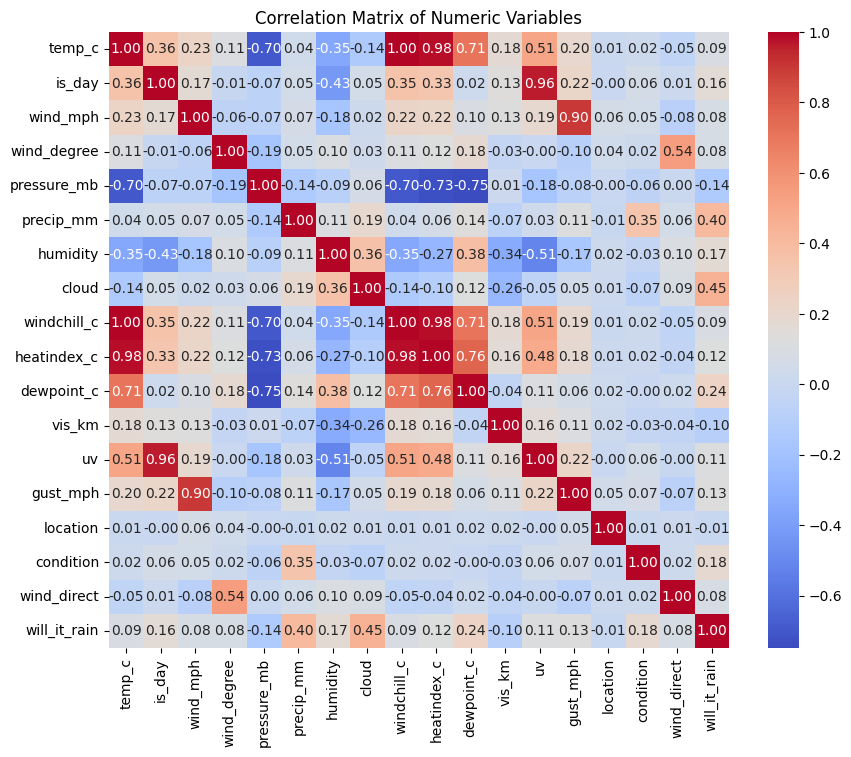

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = ['temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'location',
 'condition',
 'wind_direct',
 'will_it_rain',]

correlation_matrix = df.select(numeric_columns).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.show()


# Dataset dự đoán nhiệt độ

Đối với dữ liệu để dự đoán nhiệt độ, ta sẽ loại bỏ các biến có tương quan cao như dewpoint, heatindex, windchill, pressure để tránh đa cộng tuyến

In [ ]:
df_temp = df['location_name',
 'time',
 'temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'precip_mm',
 'humidity',
 'cloud',
 'vis_km',
 'uv',
 'gust_mph',
 'location',
 'condition',
 'wind_direct']

## Chia tập train, test

In [ ]:
from pyspark.sql.functions import rand

train_df, test_df, val_df = df_temp.randomSplit([0.7, 0.2, 0.1], seed=42)

print(f"Train set size: {train_df.count()}")
print(f"Test set size: {test_df.count()}")
print(f"Validation set size: {val_df.count()}")


Train set size: 388236
Test set size: 110649
Validation set size: 55899


## Stardard Scale (optional)

Mô hình nào cần scale để chạy tốt hơn thì hãy sử dụng

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

numeric_cols = ['is_day',
 'wind_mph',
 'wind_degree',
 'precip_mm',
 'humidity',
 'cloud',
 'vis_km',
 'uv',
 'gust_mph',
 'location',
 'condition',
 'wind_direct']

assembler_temp = VectorAssembler(inputCols=numeric_cols, outputCol="features")
train_df_temp_assembled = assembler_temp.transform(train_df)

scaler_temp = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model_temp = scaler_temp.fit(train_df_temp_assembled)

train_df_temp_scaled = scaler_model_temp.transform(train_df_temp_assembled)
test_df_temp_assembled = assembler_temp.transform(test_df)
test_df_temp_scaled = scaler_model_temp.transform(test_df_temp_assembled)

train_df_temp_scaled.select("features", "scaled_features").show(5)
test_df_temp_scaled.select("features", "scaled_features").show(5)


+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[0.0,4.9,164.0,0....|[-1.0188925663688...|
|[0.0,3.8,164.0,0....|[-1.0188925663688...|
|[0.0,3.4,154.0,0....|[-1.0188925663688...|
|[0.0,2.9,152.0,0....|[-1.0188925663688...|
|[0.0,3.4,156.0,0....|[-1.0188925663688...|
+--------------------+--------------------+
only showing top 5 rows

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[0.0,3.4,161.0,0....|[-1.0188925663688...|
|[1.0,6.7,150.0,0....|[0.98145521643261...|
|[1.0,9.8,145.0,0....|[0.98145521643261...|
|[1.0,10.7,132.0,0...|[0.98145521643261...|
|[1.0,9.4,125.0,0....|[0.98145521643261...|
+--------------------+--------------------+
only showing top 5 rows



# Sarimax

In [ ]:
# kiểm tra tính dừng
df_temp.printSchema()


root
 |-- location_name: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- temp_c: double (nullable = true)
 |-- is_day: integer (nullable = true)
 |-- wind_mph: double (nullable = true)
 |-- wind_degree: integer (nullable = true)
 |-- precip_mm: double (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- cloud: integer (nullable = true)
 |-- vis_km: double (nullable = true)
 |-- uv: double (nullable = true)
 |-- gust_mph: double (nullable = true)
 |-- location: double (nullable = false)
 |-- condition: double (nullable = false)
 |-- wind_direct: double (nullable = false)



In [ ]:
!pip install statsmodels

In [ ]:
# Chuyển đổi Spark DataFrame thành Pandas DataFrame
pandas_df = df_temp.toPandas()

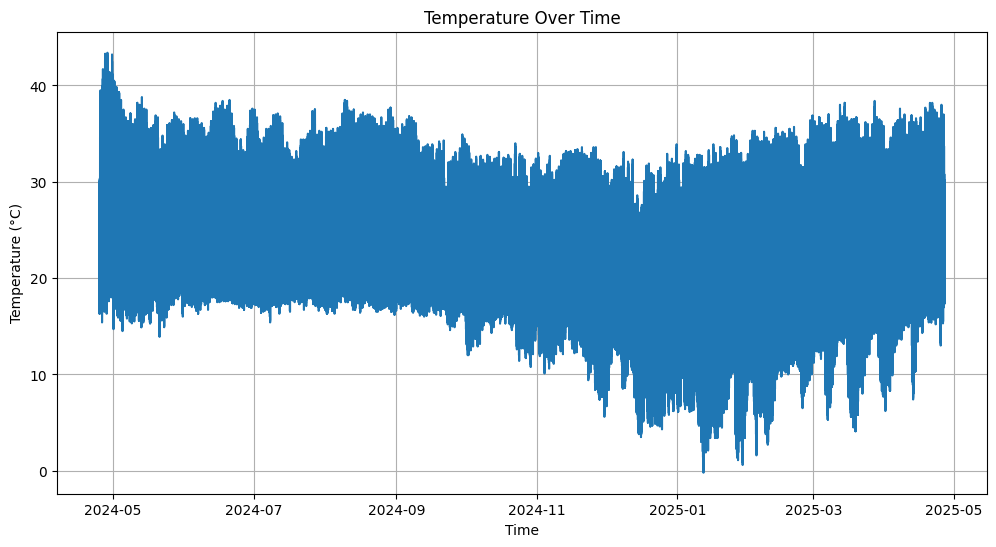

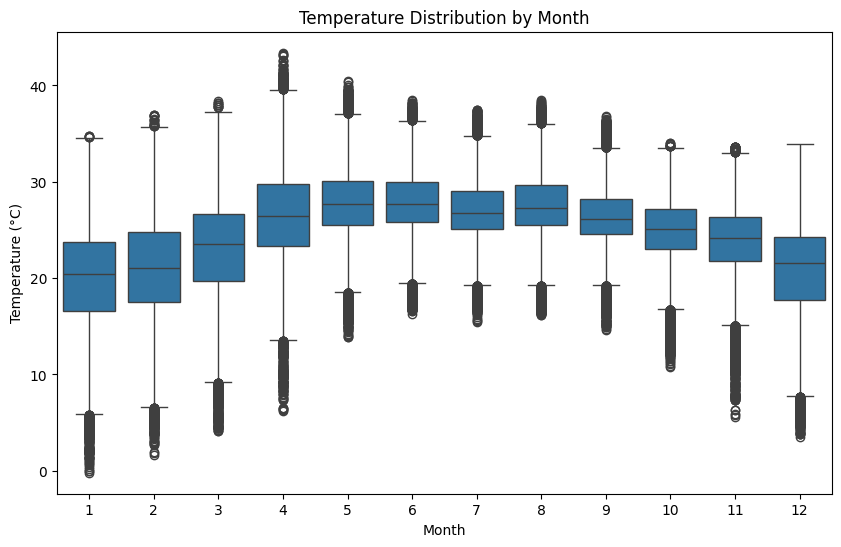

In [ ]:
# Chuyển đổi cột 'time' thành kiểu datetime
pandas_df['time'] = pd.to_datetime(pandas_df['time'])

# Sắp xếp dữ liệu theo thời gian
pandas_df = pandas_df.sort_values(by='time')


# Vẽ biểu đồ nhiệt độ theo thời gian
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['time'], pandas_df['temp_c'])
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Over Time')
plt.grid(True)
plt.show()


# Vẽ biểu đồ hộp để xem xét tính mùa vụ
plt.figure(figsize=(10, 6))
sns.boxplot(x=pandas_df['time'].dt.month, y=pandas_df['temp_c'])
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Distribution by Month')
plt.show()


ADF Statistic: -46.992773
p-value: 0.000000
Critical Values:


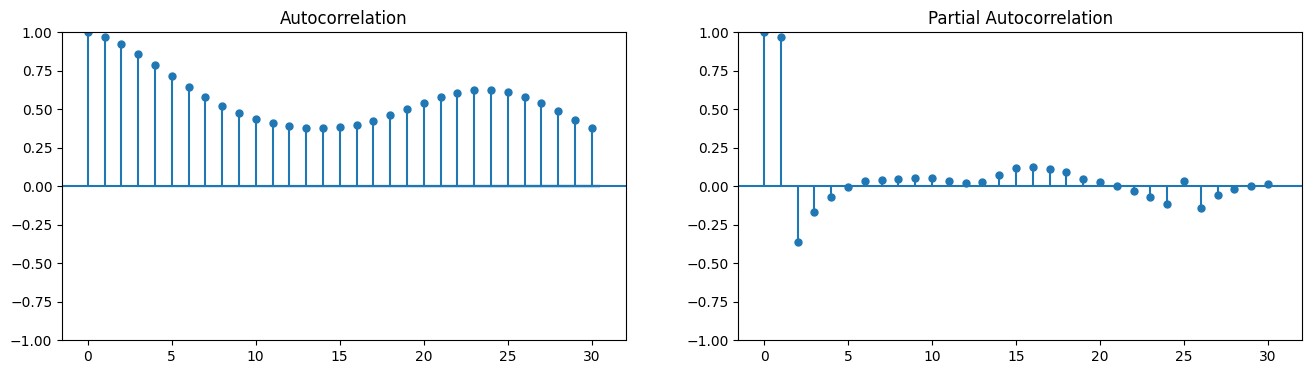

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Check for stationarity (example using Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

df_raw = pd.read_csv('./weather_dataset.csv')
pandas_df = df_raw[['location_name',
 'time',
 'temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'precip_mm',
 'humidity',
 'cloud',
 'vis_km',
 'uv',
 'gust_mph'
]]

result = adfuller(pandas_df['temp_c'], maxlag=60)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:  # If p-value > 0.05, data is likely non-stationary
    # Difference the data to achieve stationarity
    pandas_df['temp_c_diff'] = pandas_df['temp_c'].diff().dropna()

    # Plot ACF and PACF for differenced data
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(pandas_df['temp_c_diff'], lags=30, ax=axes[0])
    plot_pacf(pandas_df['temp_c_diff'], lags=30, ax=axes[1])
    plt.show()
else:
    # Plot ACF and PACF for the original data (already stationary)
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(pandas_df['temp_c'], lags=30, ax=axes[0])
    plot_pacf(pandas_df['temp_c'], lags=30, ax=axes[1])
    plt.show()


In [ ]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyspark.sql.functions import pandas_udf, PandasUDFType
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the schema for the output
output_schema = StructType([
    StructField("location_name", StringType()),
    StructField("prediction", DoubleType())
])


@pandas_udf(output_schema, PandasUDFType.GROUPED_MAP)
def train_and_predict_sarimax(pdf):
    try:
        location = pdf['location_name'].iloc[0]
        pdf = pdf.sort_values(by='time')
        y = pdf['temp_c'].values
        model = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)
        print(f"MSE: {model_fit.mse}")
        predictions = model_fit.predict(start=len(y), end=len(y))
        return pd.DataFrame({'location_name': [location], 'prediction': predictions})
    except Exception as e:
        print(f"Error processing {location}: {e}")
        return pd.DataFrame([], columns=["location_name", "prediction"])

# Apply the UDF to the training data
results = train_df_temp_scaled.groupby("location_name").apply(train_and_predict_sarimax)
results.show()


/usr/local/lib/python3.11/dist-packages/pyspark/sql/pandas/group_ops.py:104: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+----------------+------------------+
|   location_name|        prediction|
+----------------+------------------+
| Ap Tan Qui Kinh| 27.43461553206326|
|         Bac Can|23.093128766015564|
|         Ben Tre|25.581269835512863|
|          Ca Mau|27.682254098071823|
|         Cam Pha|23.573234153651974|
|         Can Tho| 26.89397388021767|
|        Chau Doc|28.846132290449354|
|       Dien Bien|24.001238316457187|
|        Dong Hoi|24.340675495735272|
|       Dong Xoai|   26.240427958956|
|         Ha Tinh| 24.05265611152658|
|       Hai Duong| 23.17390391646737|
|       Hai Phong|23.921854512542463|
|Ho Chi Minh City| 28.38243049835157|
|        Lang Son|22.355267739919036|
|          My Tho|25.386832671163106|
|        Nam Dinh|24.232176948994027|
|       Ninh Binh|24.116917838558233|
|      Ninh Quang|25.094870626943983|
|          Phu Ly| 24.45517337352221|
+----------------+------------------+
only showing top 20 rows



In [ ]:
import pandas as pd

# Chuyển đổi kết quả dự đoán Spark DataFrame thành Pandas DataFrame để tính MAE
results_pandas = results.toPandas()
test_pandas = test_df_temp_scaled.select("location_name", "temp_c").toPandas()
# Merge kết quả dự đoán với giá trị thực tế từ tập test
merged_df = pd.merge(results_pandas, test_pandas, on="location_name", how="inner")

# Tính Mean Absolute Error (MAE)
if not merged_df.empty:
    mae = mean_absolute_error(merged_df['temp_c'], merged_df['prediction'])
    rmse = mean_squared_error(merged_df['temp_c'], merged_df['prediction'])
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Quared Error (RMSE): {rmse}")
else:
    print("No overlapping locations between predictions and test data to calculate MAE.")


Mean Absolute Error (MAE): 3.57009575942036
Mean Absolute Error (MAE): 21.139182044395756


# Gradient Boosting

In [ ]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pyspark.sql.functions import pandas_udf, PandasUDFType
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.pipeline import Pipeline
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, lag, lead

# Create a window specification ordered by time within each location
windowSpec = Window.partitionBy("location_name").orderBy("time")

# Add lagged features for temp_c
df_temp = df_temp.withColumn("temp_c_lag1", lag("temp_c", 1).over(windowSpec))
df_temp = df_temp.withColumn("temp_c_lag2", lag("temp_c", 2).over(windowSpec))
df_temp = df_temp.withColumn("temp_c_lead1", lead("temp_c", 1).over(windowSpec))

# Drop rows with nulls created by lagged features (first few rows for each location)
df_temp = df_temp.dropna(subset=["temp_c_lag1", "temp_c_lag2", "temp_c_lead1"])

from pyspark.sql.functions import unix_timestamp
df_temp = df_temp.withColumn("time_ts", unix_timestamp("time"))

# Define features and target for Gradient Boosting
feature_cols_gbt = [
    'time_ts',
    'is_day',
    'wind_mph',
    'wind_degree',
    'precip_mm',
    'humidity',
    'cloud',
    'vis_km',
    'uv',
    'gust_mph',
    'location',
    'condition',
    'wind_direct',
    'temp_c_lag1',
    'temp_c_lag2',
]

assembler_gbt = VectorAssembler(inputCols=feature_cols_gbt, outputCol="features")
gbt = GBTRegressor(featuresCol="features", labelCol="temp_c", maxIter=200, maxBins=8000)

pipeline_gbt = Pipeline(stages=[assembler_gbt, gbt])

train_df_gbt, test_df_gbt, val_df_gbt = df_temp.randomSplit([0.7, 0.2, 0.1], seed=42)

print(f"Train set size for GBT: {train_df_gbt.count()}")
print(f"Test set size for GBT: {test_df_gbt.count()}")
print(f"Validation set size for GBT: {val_df_gbt.count()}")

model_gbt = pipeline_gbt.fit(train_df_gbt)

predictions_gbt = model_gbt.transform(test_df_gbt)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="temp_c", predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions_gbt)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_gbt}")

evaluator_mae = RegressionEvaluator(labelCol="temp_c", predictionCol="prediction", metricName="mae")
mae_gbt = evaluator_mae.evaluate(predictions_gbt)
print(f"Mean Absolute Error (MAE) on test data = {mae_gbt}")

predictions_gbt.select("time", "location_name", "temp_c", "prediction").show(10)


Train set size for GBT: 388082
Test set size for GBT: 110618
Validation set size for GBT: 55895
Root Mean Squared Error (RMSE) on test data = 0.4927526496244463
Mean Absolute Error (MAE) on test data = 0.34612295457348285
+-------------------+---------------+------+------------------+
|               time|  location_name|temp_c|        prediction|
+-------------------+---------------+------+------------------+
|2024-04-25 04:00:00|Ap Tan Qui Kinh|  27.2|27.289407474250286|
|2024-04-25 11:00:00|Ap Tan Qui Kinh|  37.1| 37.51702779139995|
|2024-04-25 15:00:00|Ap Tan Qui Kinh|  37.2| 37.59246610857613|
|2024-04-25 16:00:00|Ap Tan Qui Kinh|  36.2|  36.4113266152464|
|2024-04-25 17:00:00|Ap Tan Qui Kinh|  35.2|35.632239907264776|
|2024-04-25 21:00:00|Ap Tan Qui Kinh|  29.3|29.275347559854755|
|2024-04-25 23:00:00|Ap Tan Qui Kinh|  28.4|28.616527611565168|
|2024-04-26 01:00:00|Ap Tan Qui Kinh|  27.8| 27.97596887117583|
|2024-04-26 02:00:00|Ap Tan Qui Kinh|  28.0|27.755992964923617|
|2024-04-2

Visualizing predictions for Ap Tan Qui Kinh


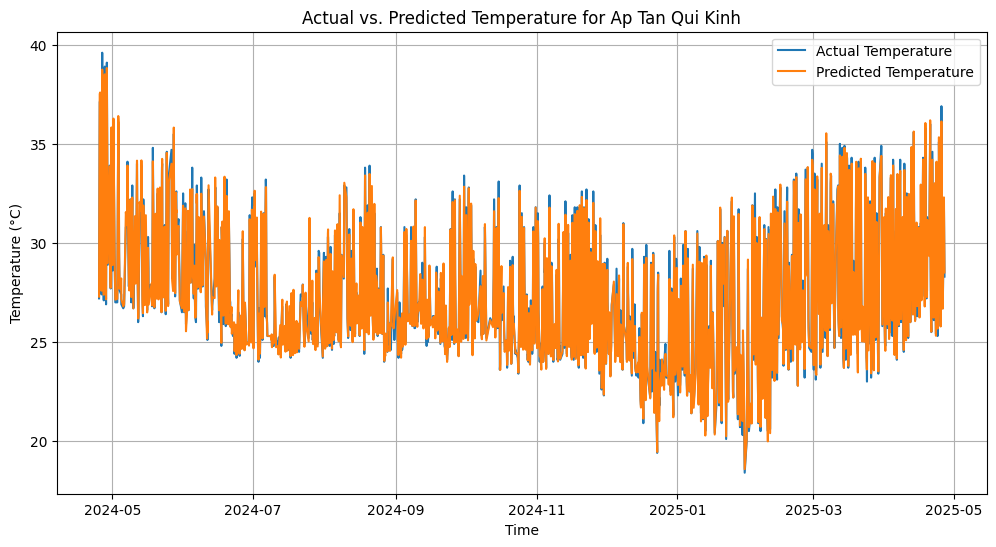

Visualizing predictions for Bac Can


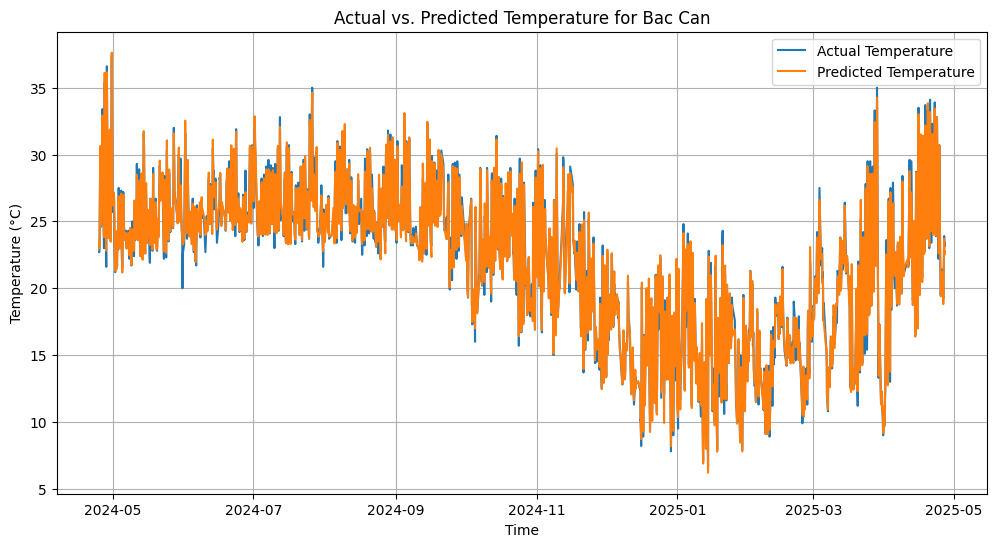

Visualizing predictions for Ben Tre


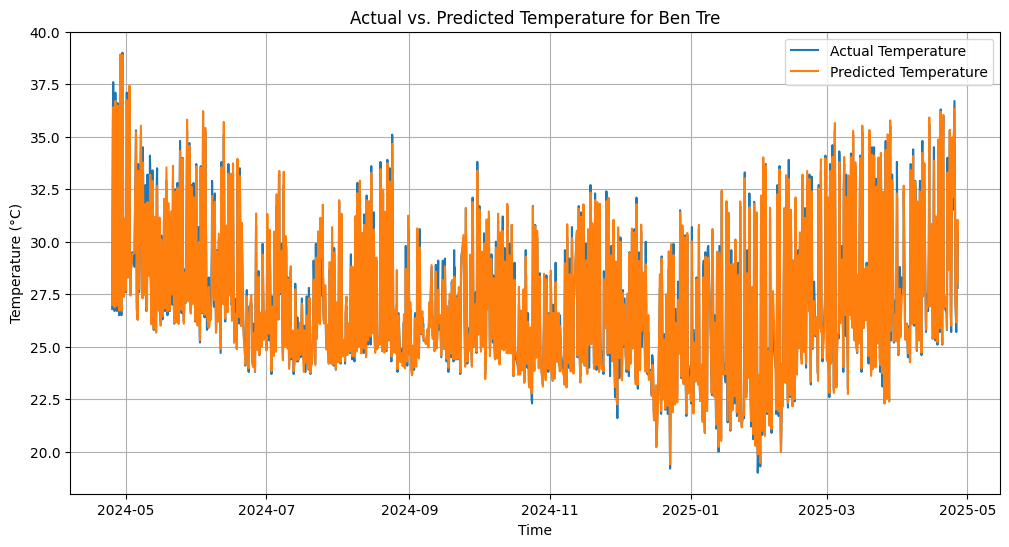

Visualizing predictions for Ca Mau


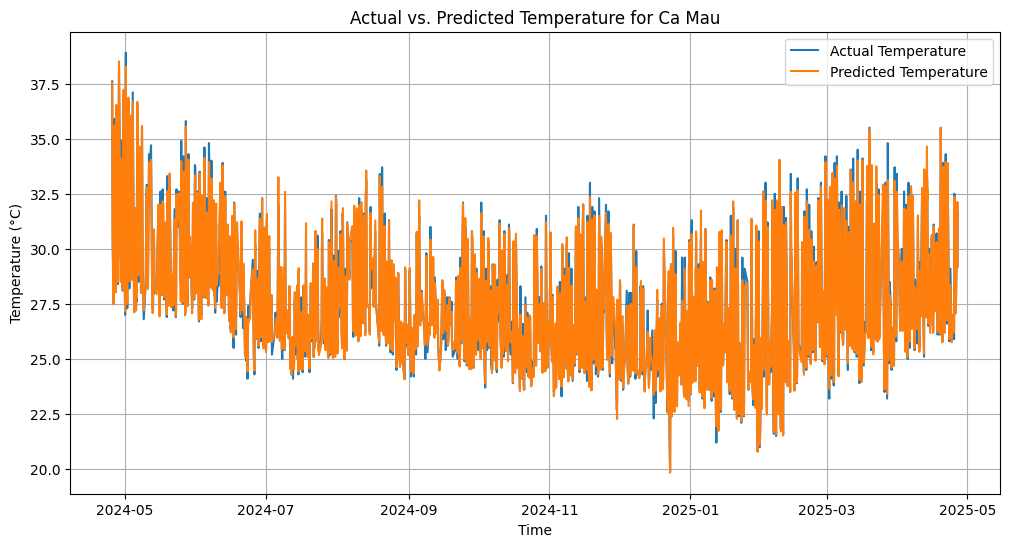

Visualizing predictions for Cam Pha


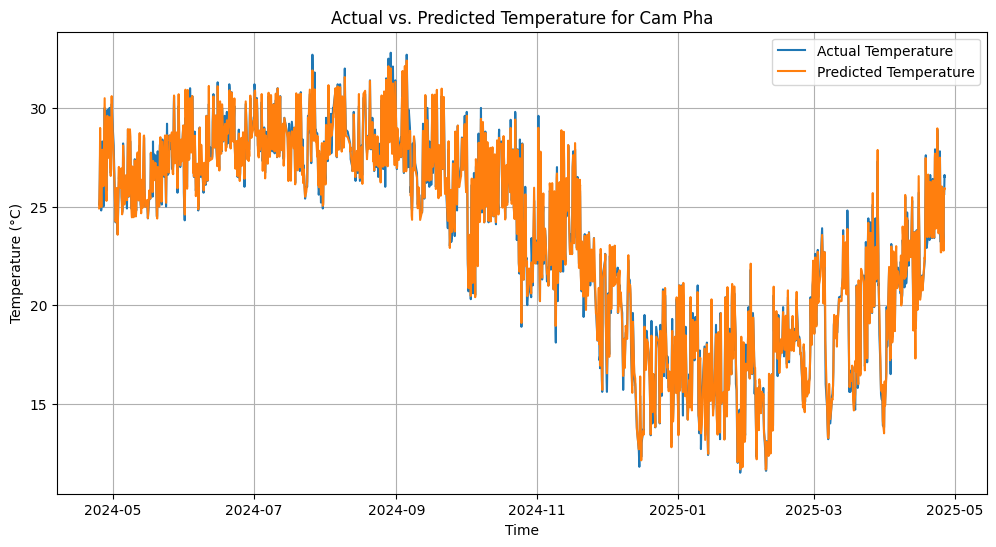

Visualizing predictions for Can Tho


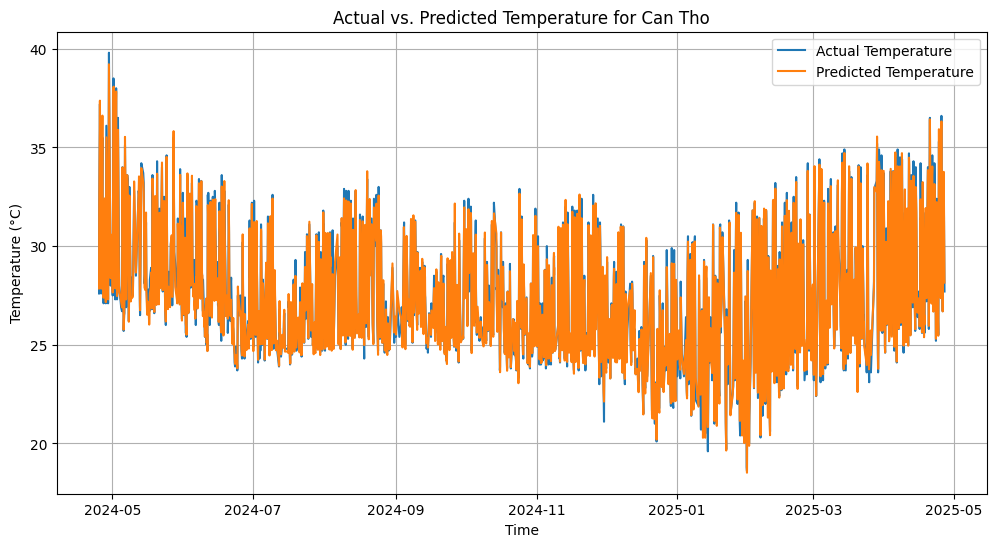

Visualizing predictions for Chau Doc


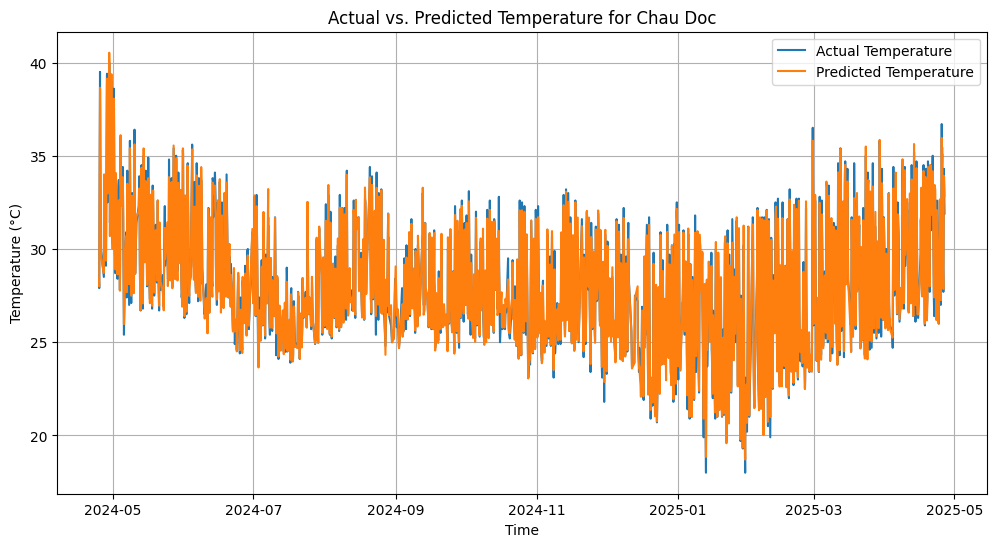

Visualizing predictions for Dien Bien


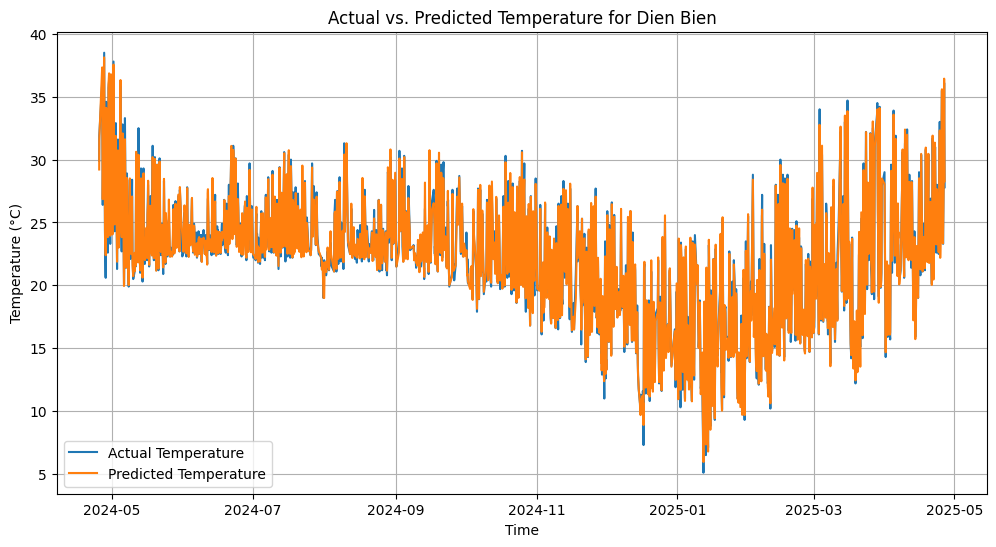

Visualizing predictions for Dong Hoi


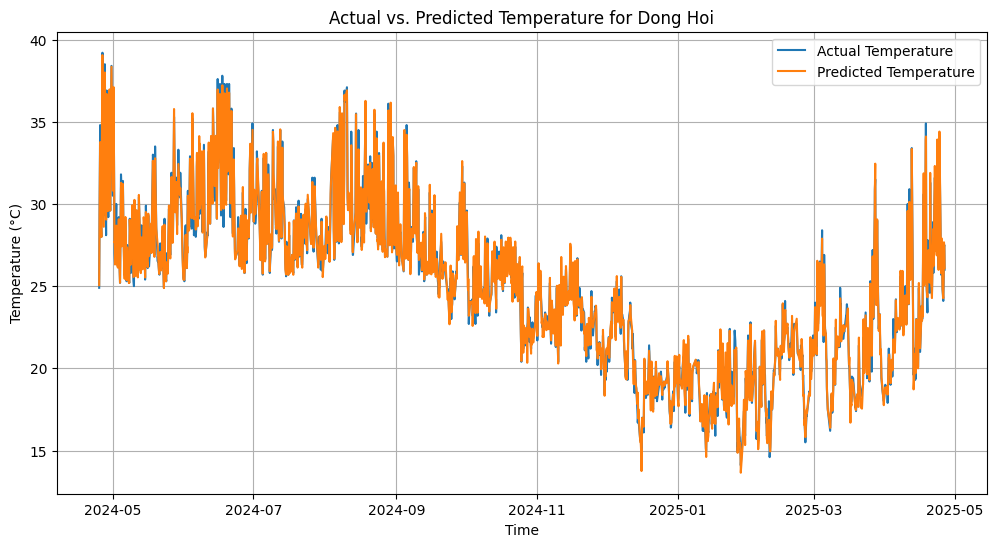

Visualizing predictions for Dong Xoai


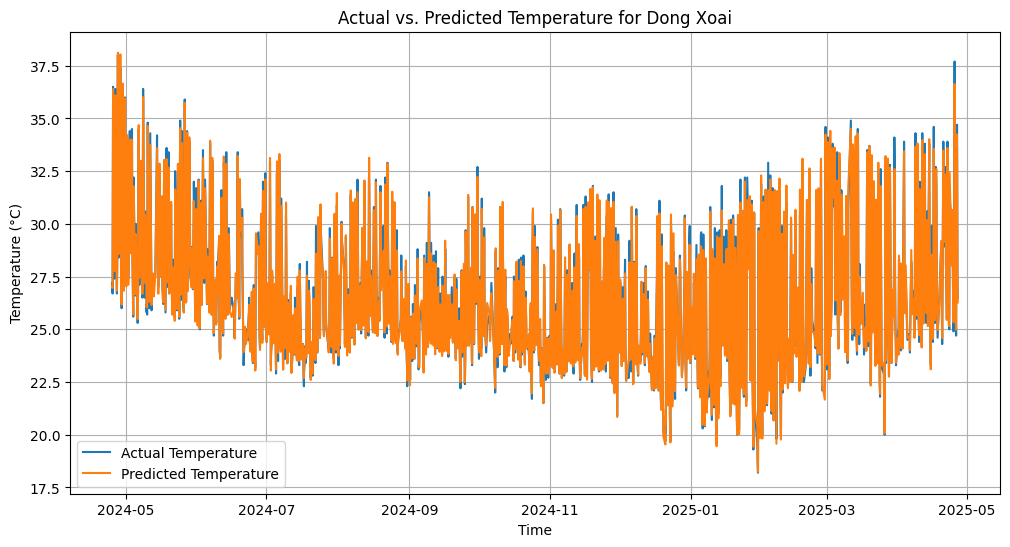

Visualizing predictions for Ha Tinh


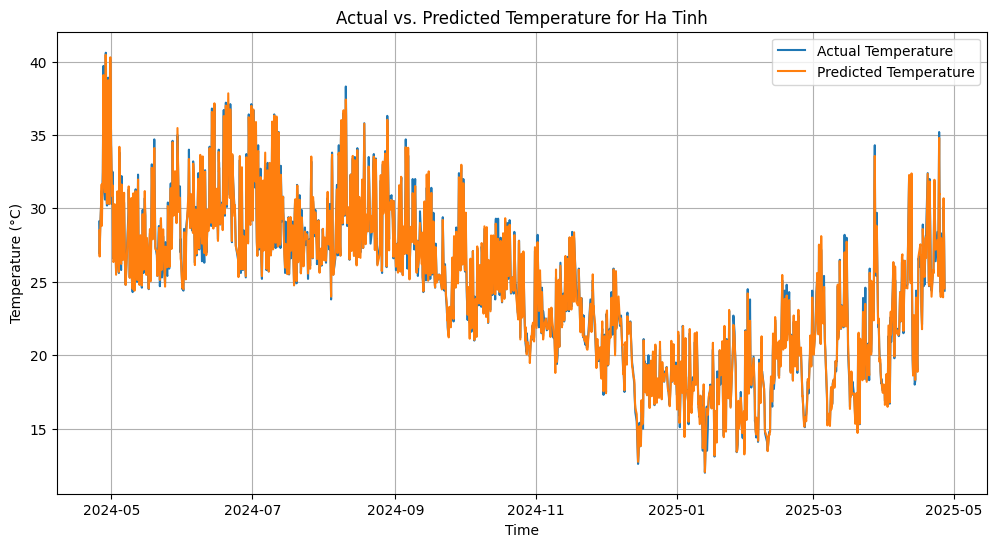

Visualizing predictions for Hai Duong


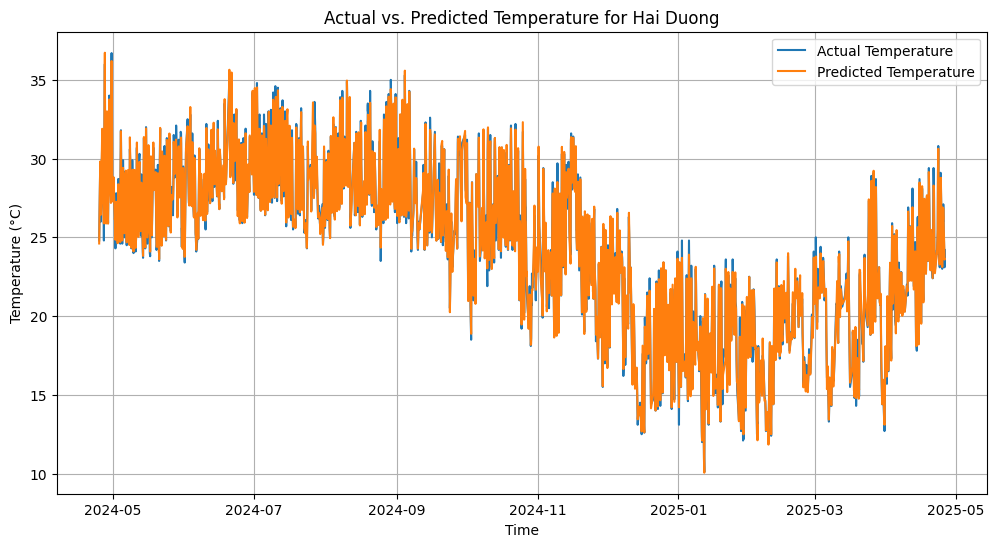

Visualizing predictions for Hai Phong


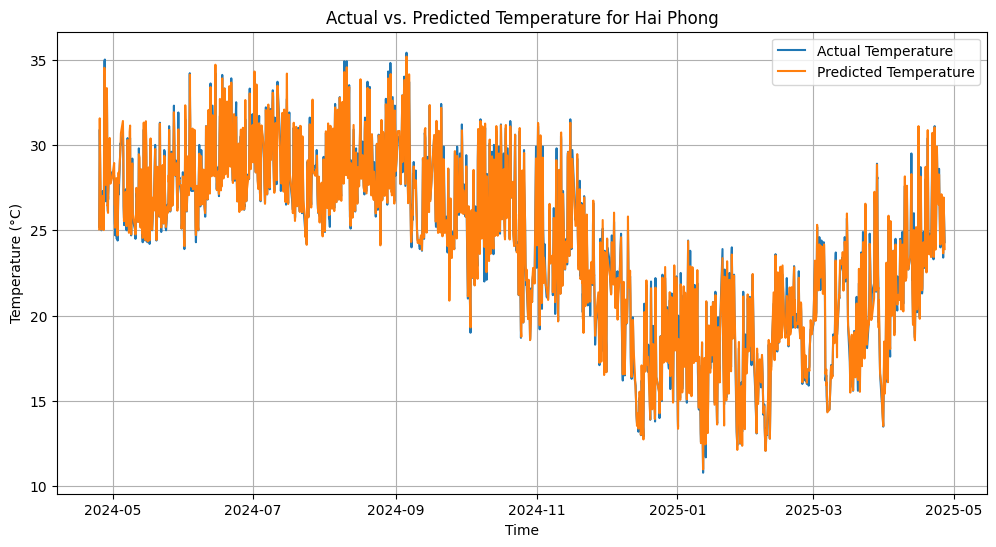

Visualizing predictions for Ho Chi Minh City


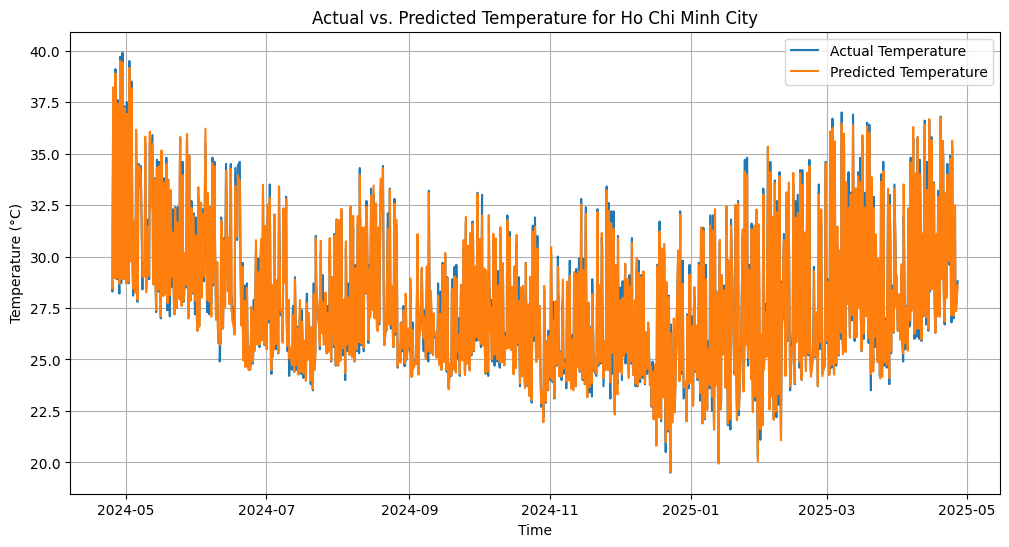

Visualizing predictions for Lang Son


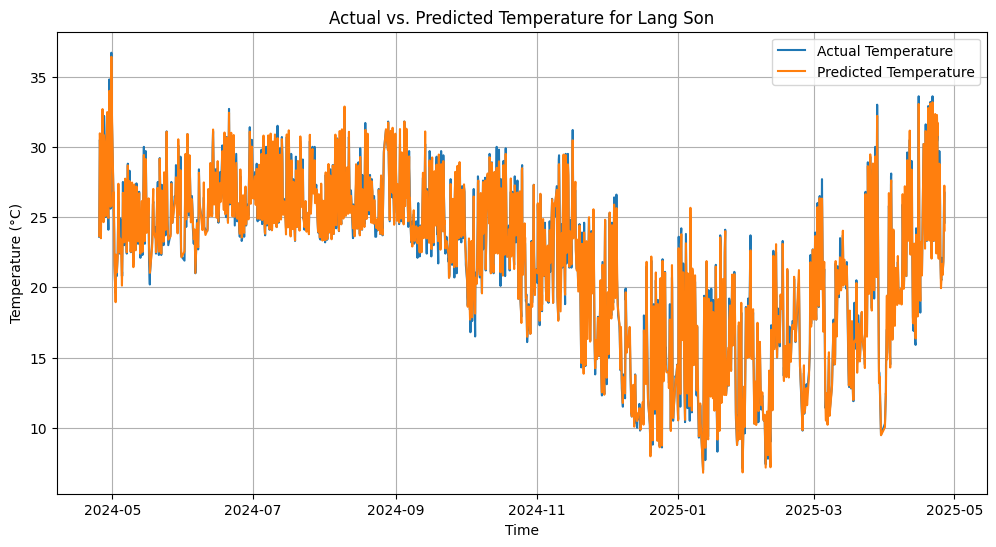

Visualizing predictions for My Tho


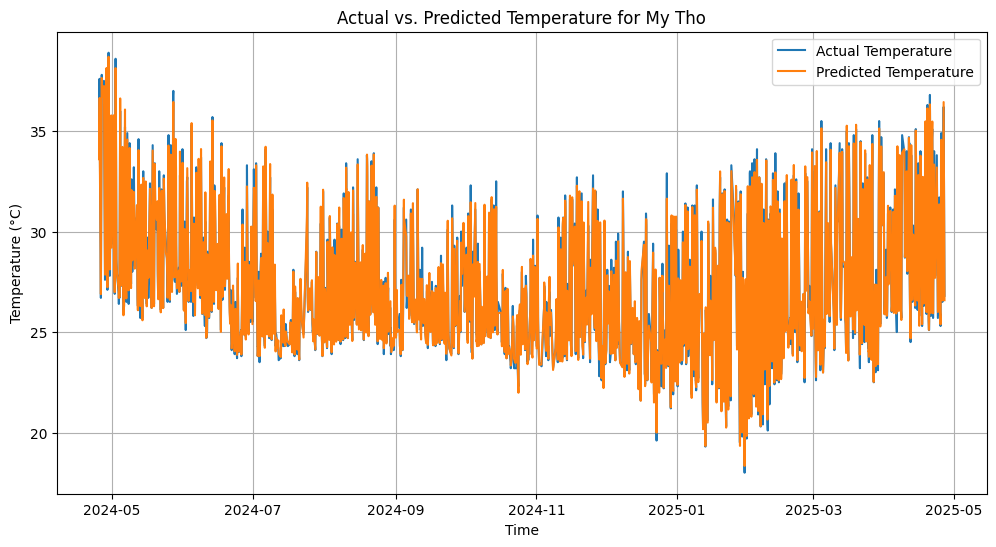

Visualizing predictions for Nam Dinh


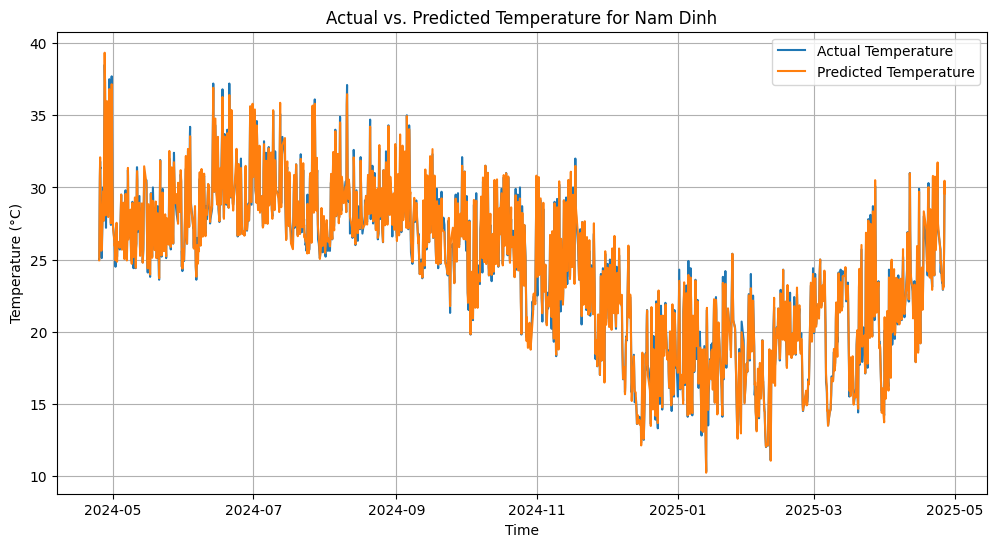

Visualizing predictions for Ninh Binh


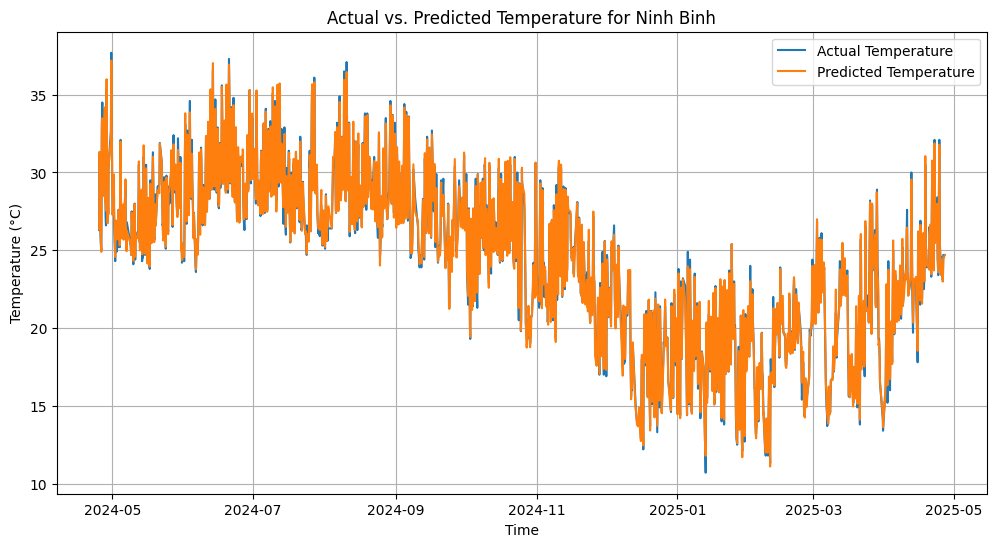

Visualizing predictions for Ninh Quang


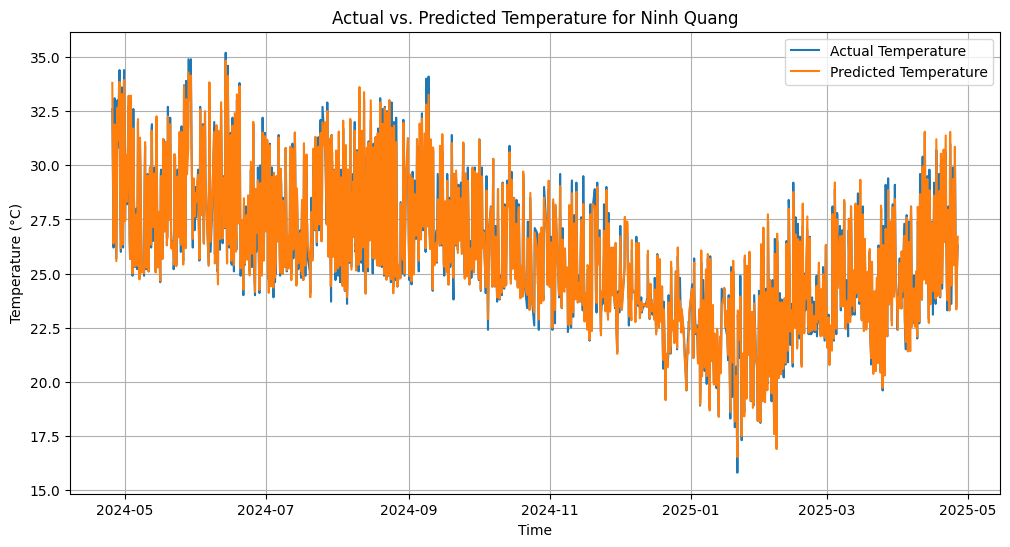

Visualizing predictions for Phu Ly


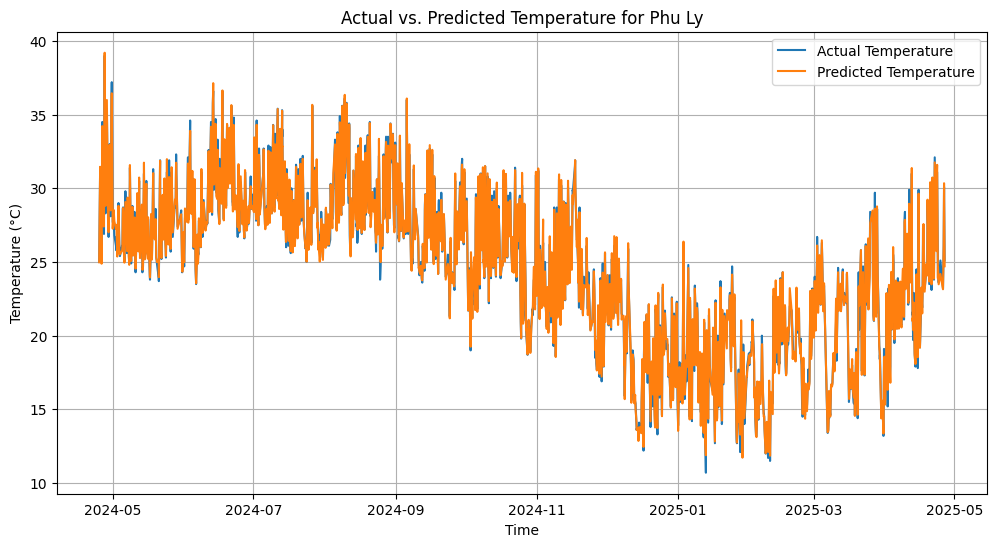

Visualizing predictions for Play Cu


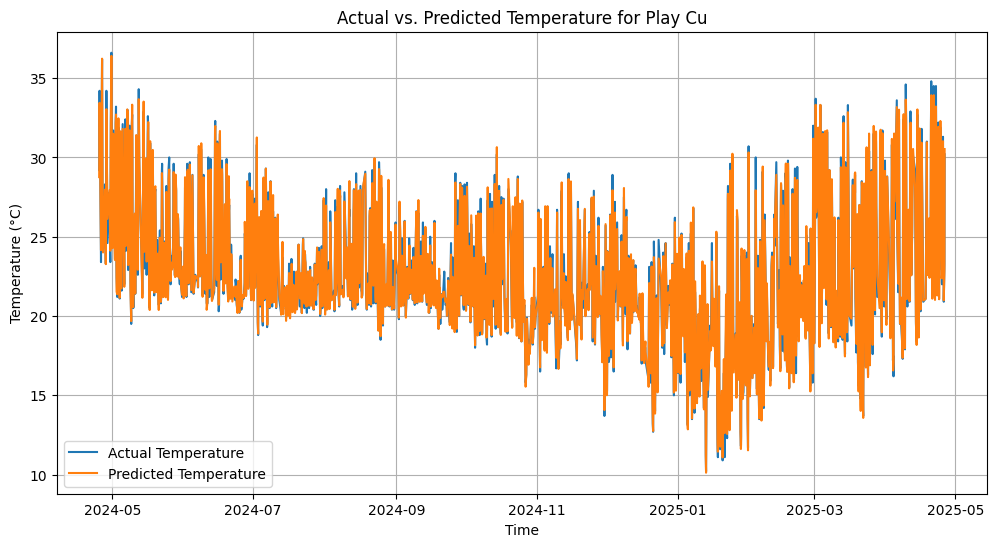

Visualizing predictions for Tay Ninh


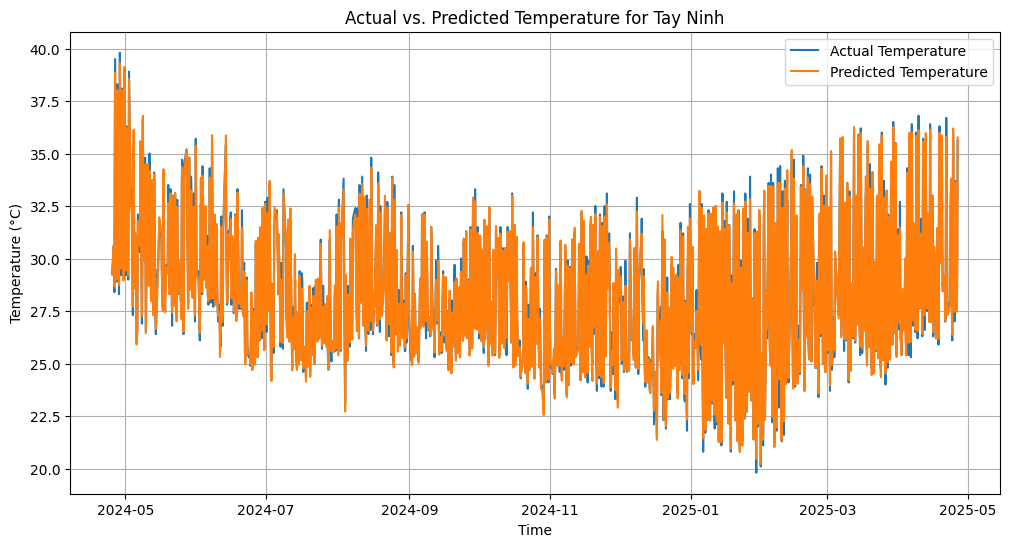

Visualizing predictions for Thai Binh


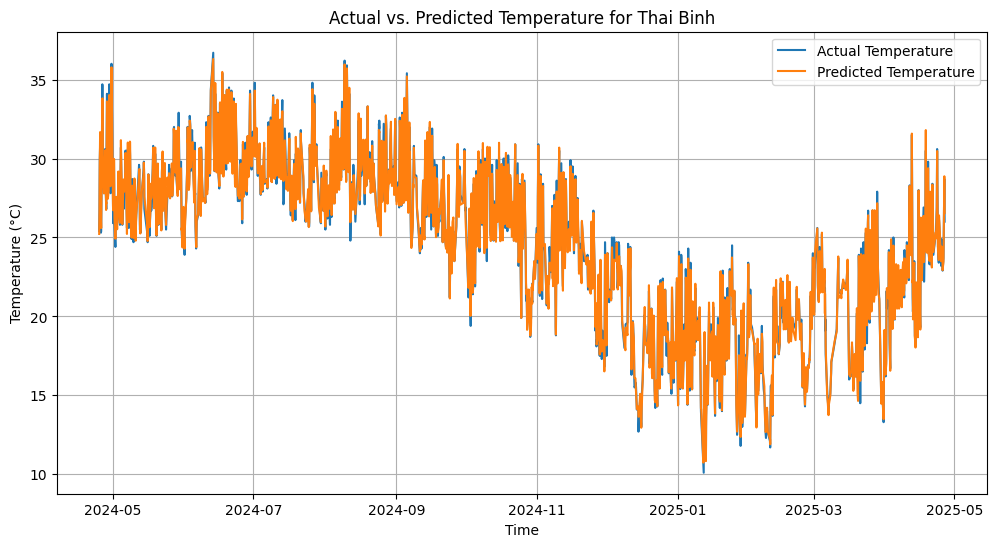

Visualizing predictions for Thai Nguyen


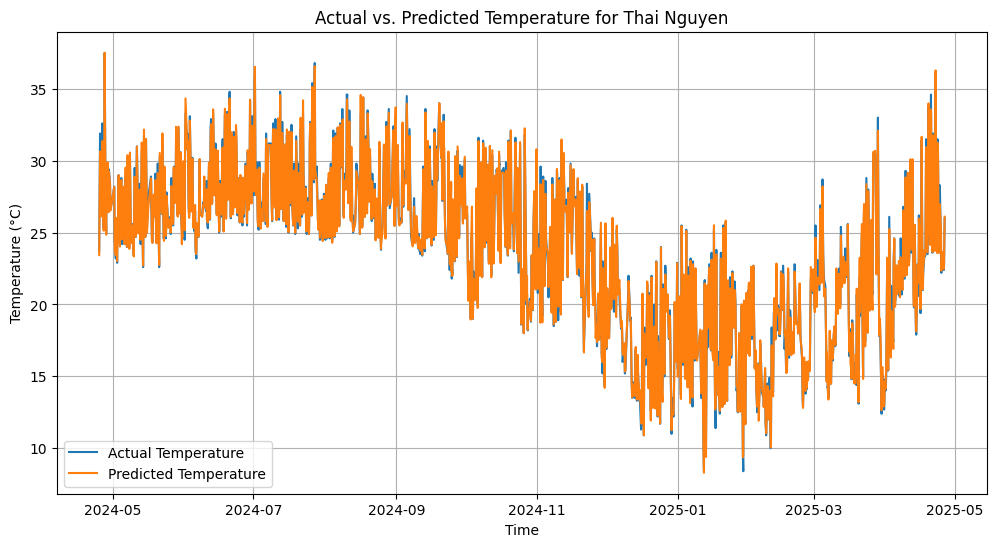

Visualizing predictions for Thon Suoi La


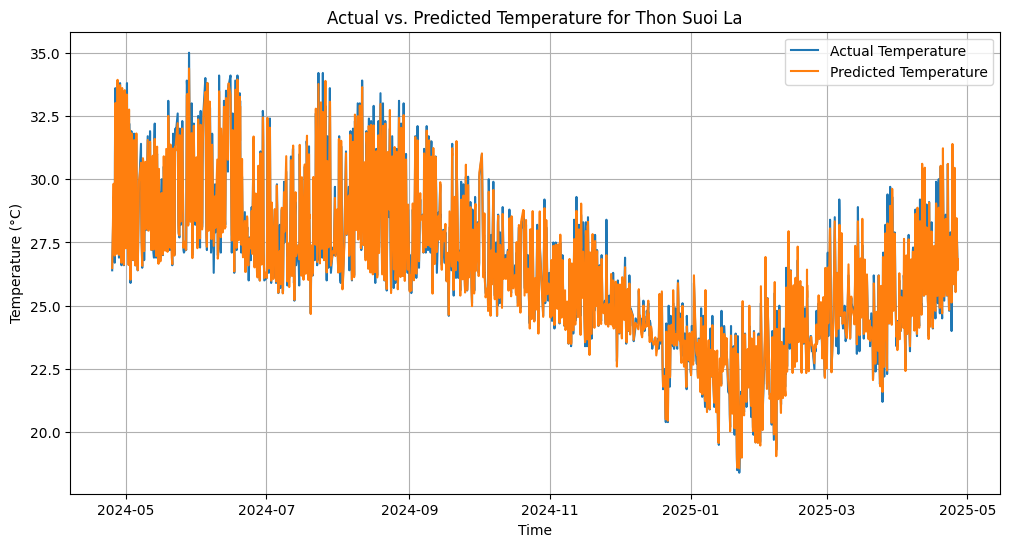

Visualizing predictions for Tuyen Quang


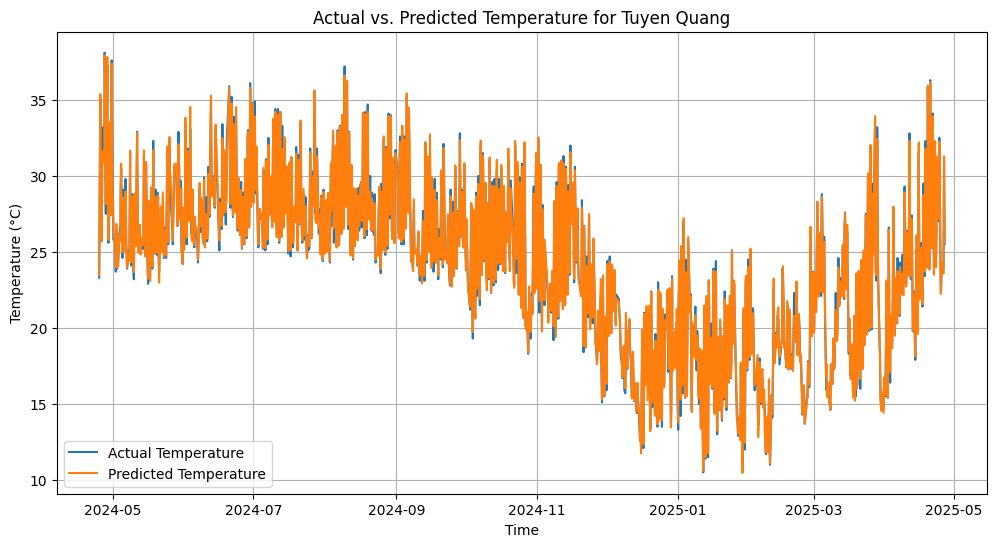

Visualizing predictions for Vinh Long


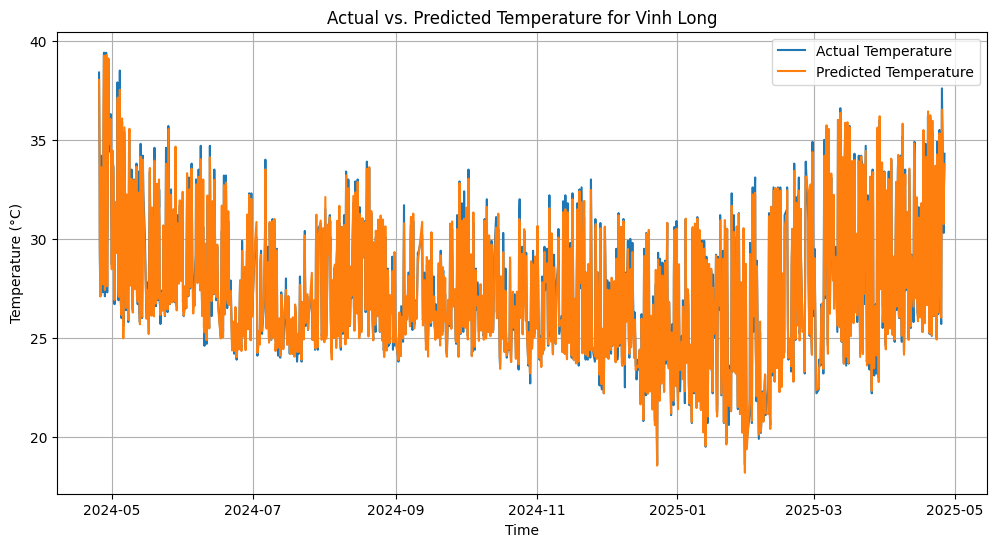

Visualizing predictions for Vung Tau


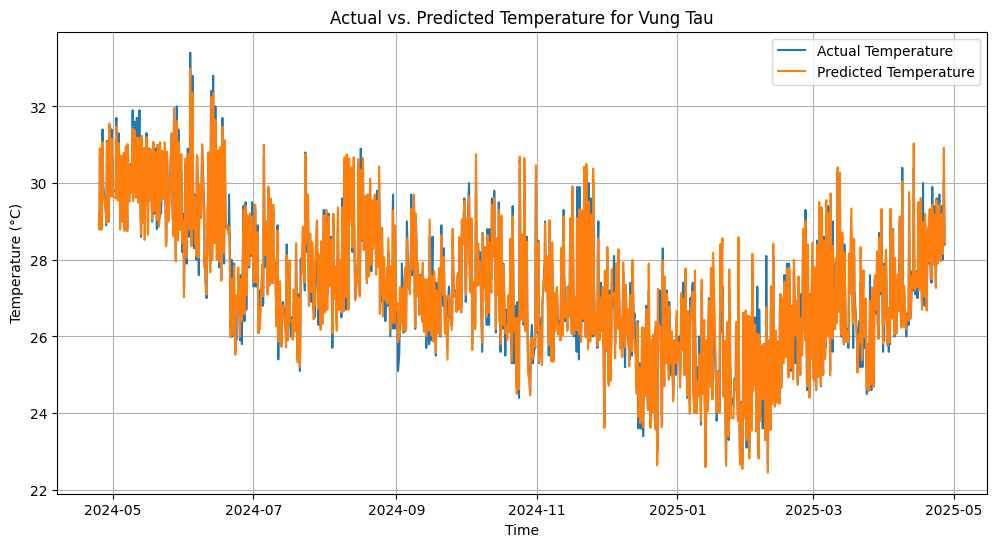

Visualizing predictions for Xom Ong Ho


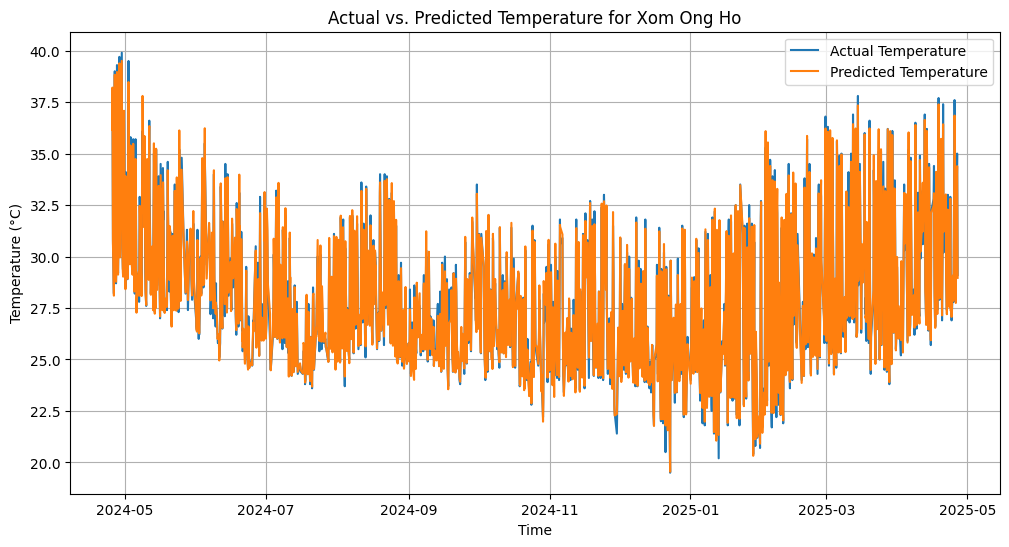

Visualizing predictions for Xuan Loc Ha


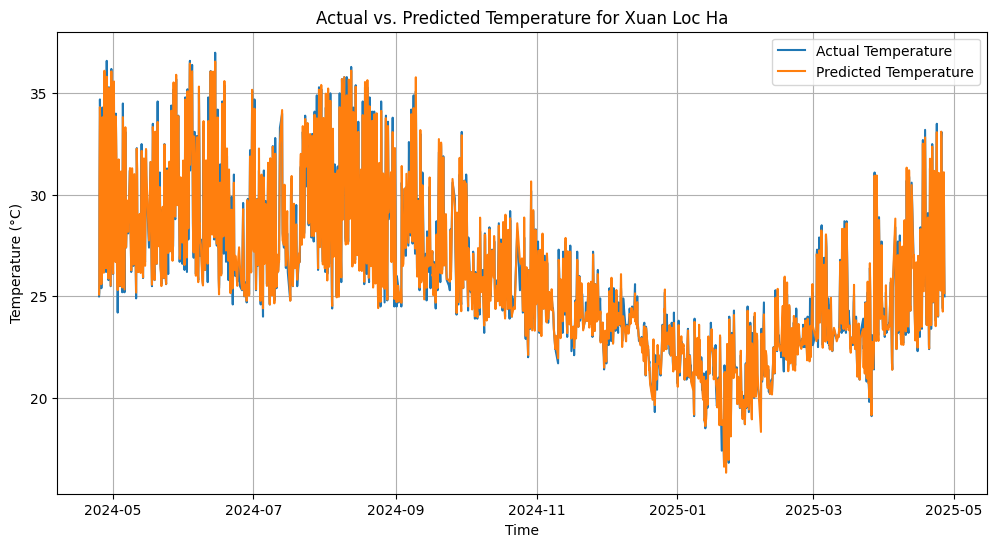

Visualizing predictions for Yen Bai


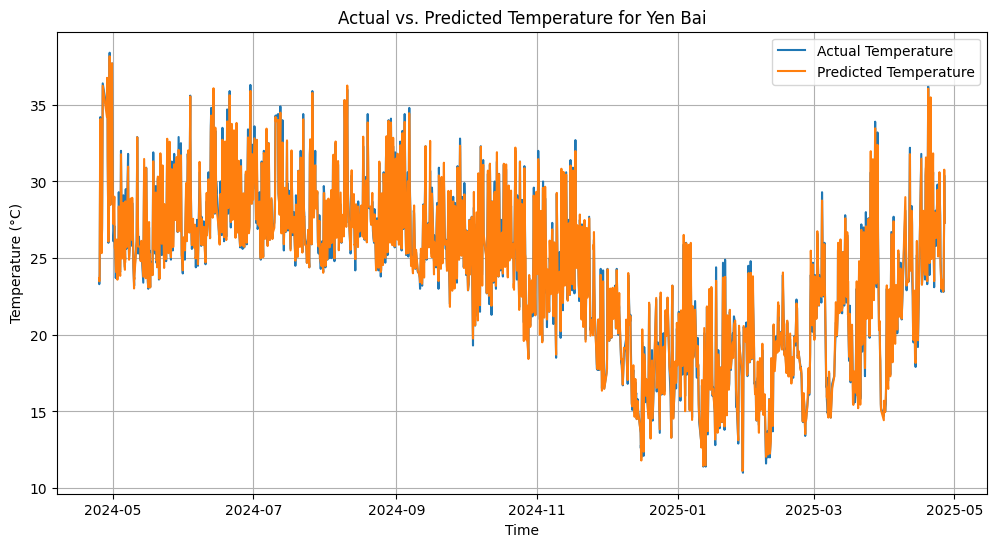

Visualizing predictions for Atba Village


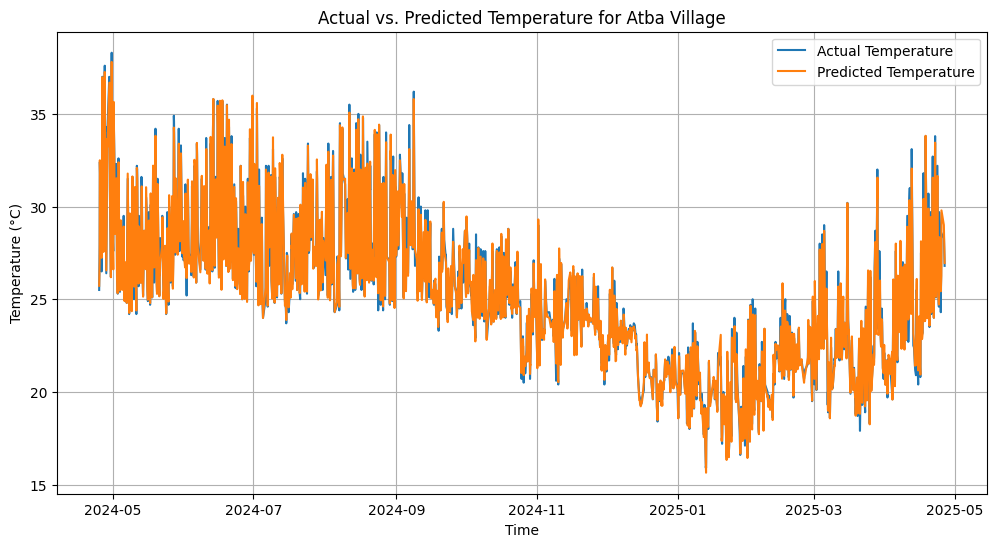

Visualizing predictions for Bac Giang


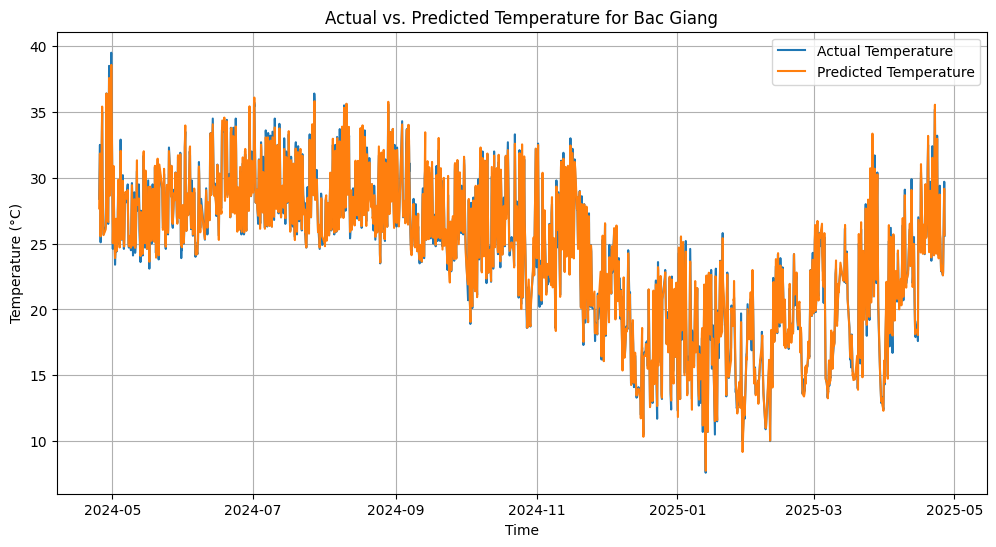

Visualizing predictions for Bac Lieu


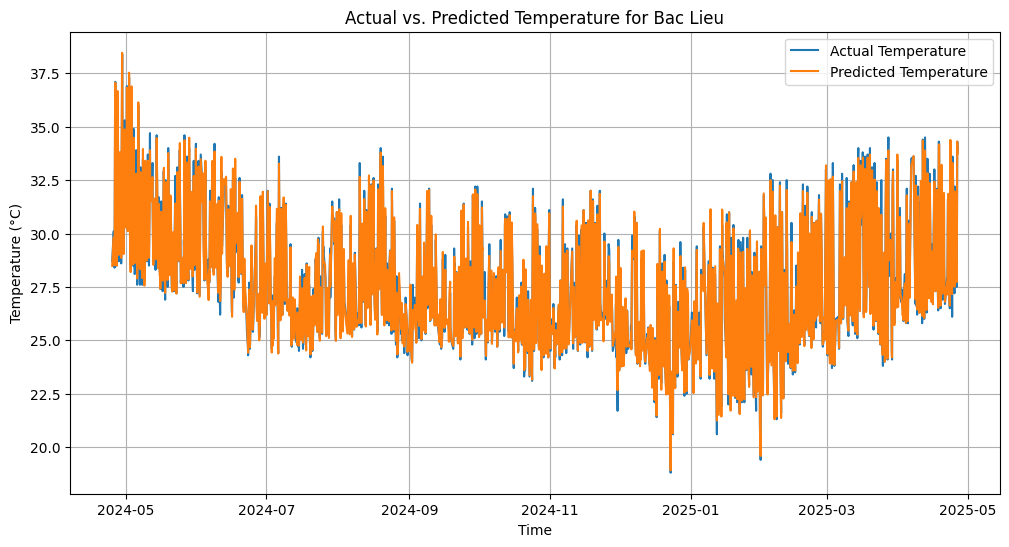

Visualizing predictions for Bac Ninh


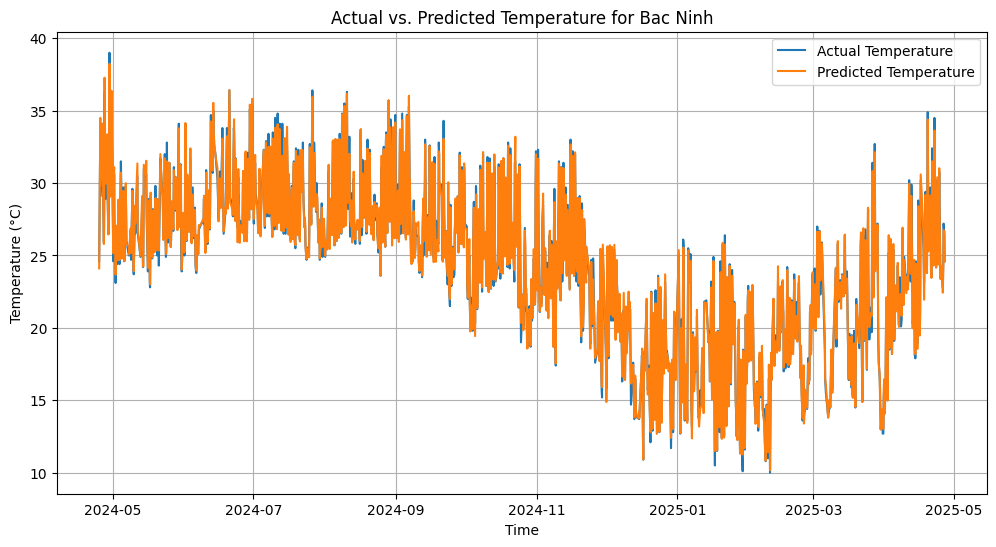

Visualizing predictions for Bien Hoa


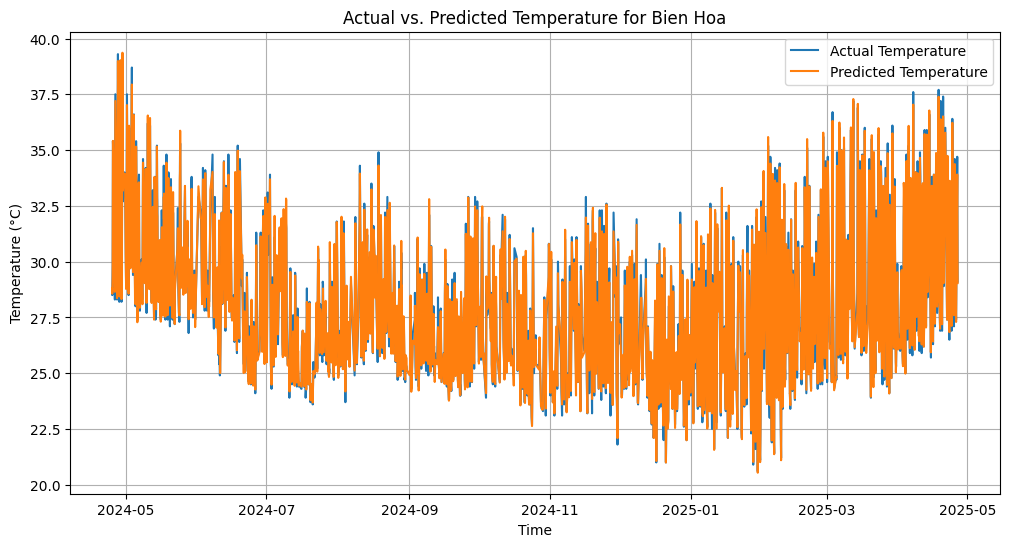

Visualizing predictions for Buon Me Thuot


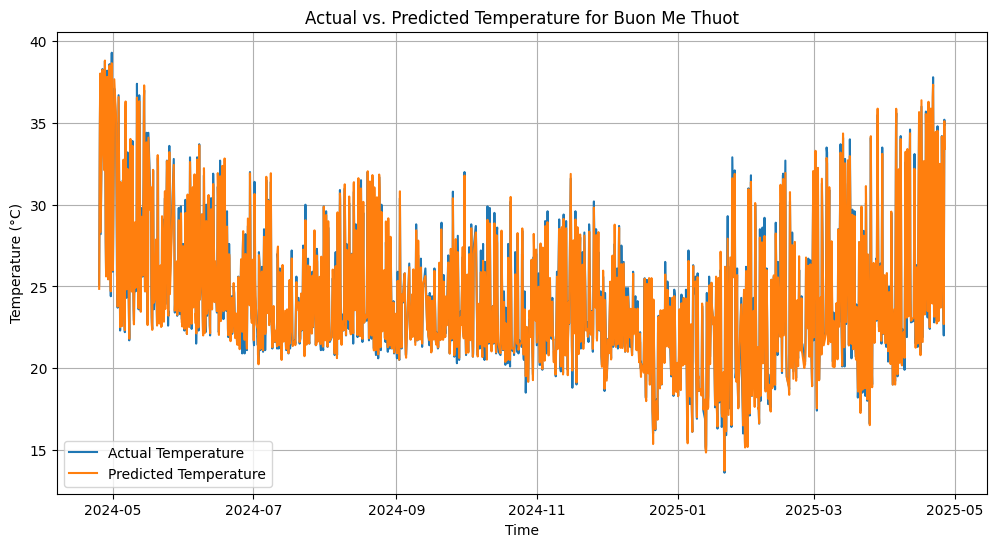

Visualizing predictions for Cao Bang


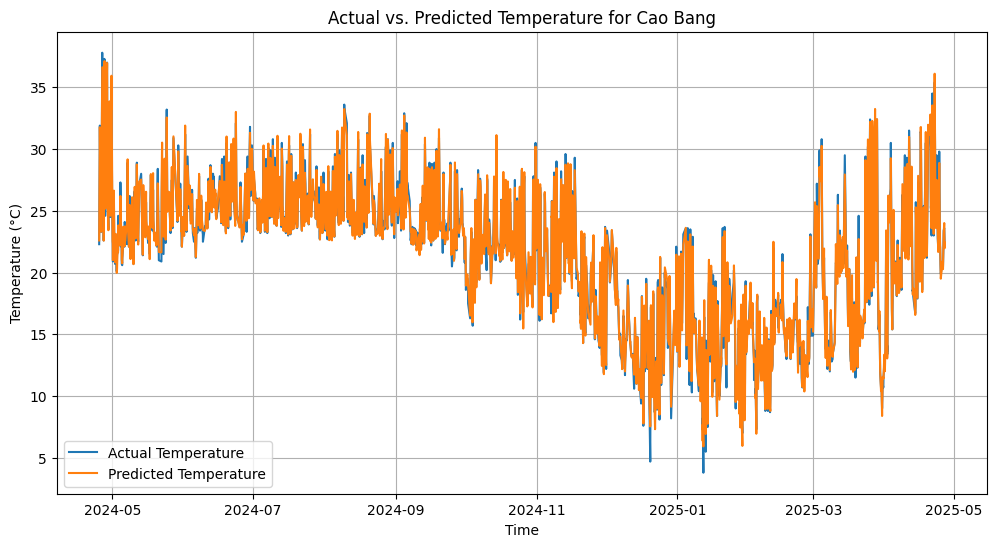

Visualizing predictions for Da Lat


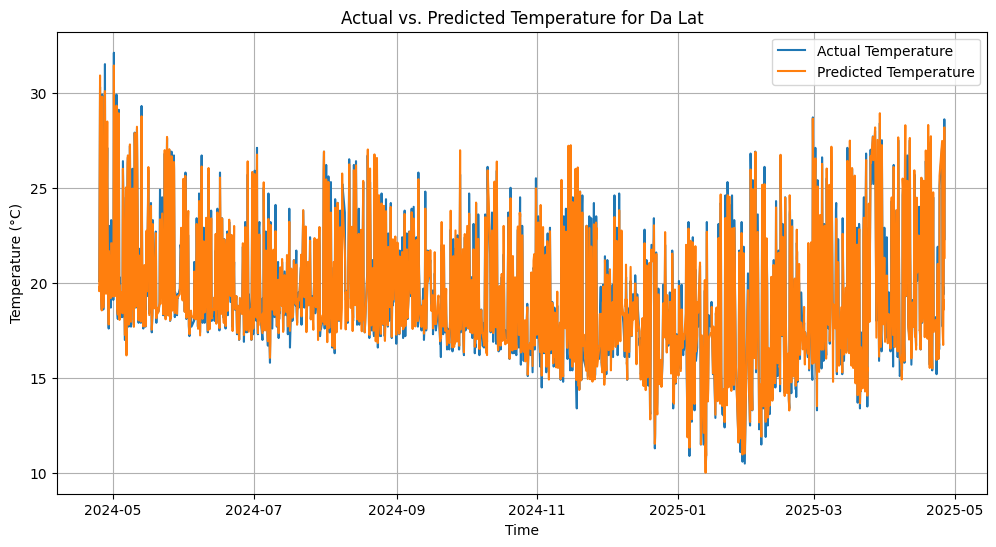

Visualizing predictions for Ha Giang


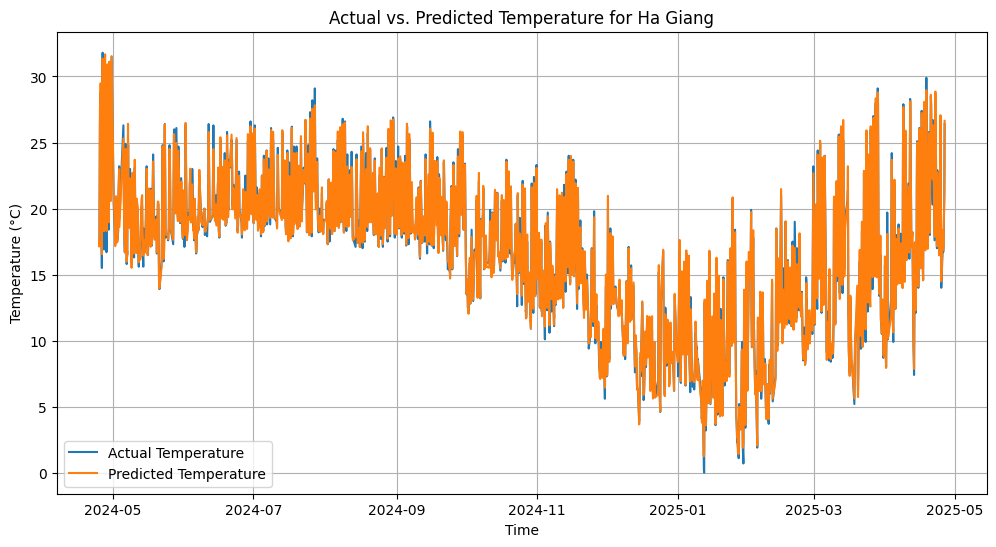

Visualizing predictions for Ha Noi


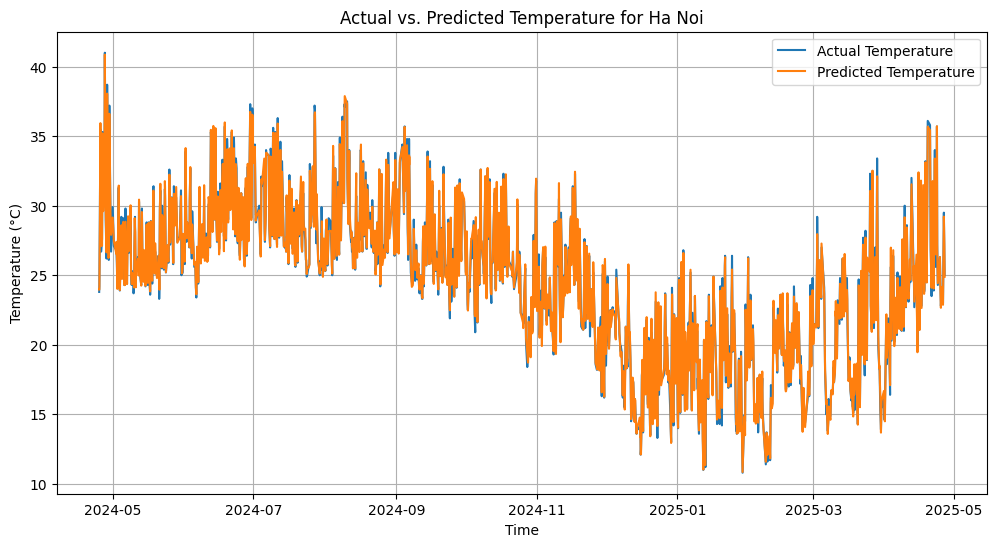

Visualizing predictions for Hoa Binh


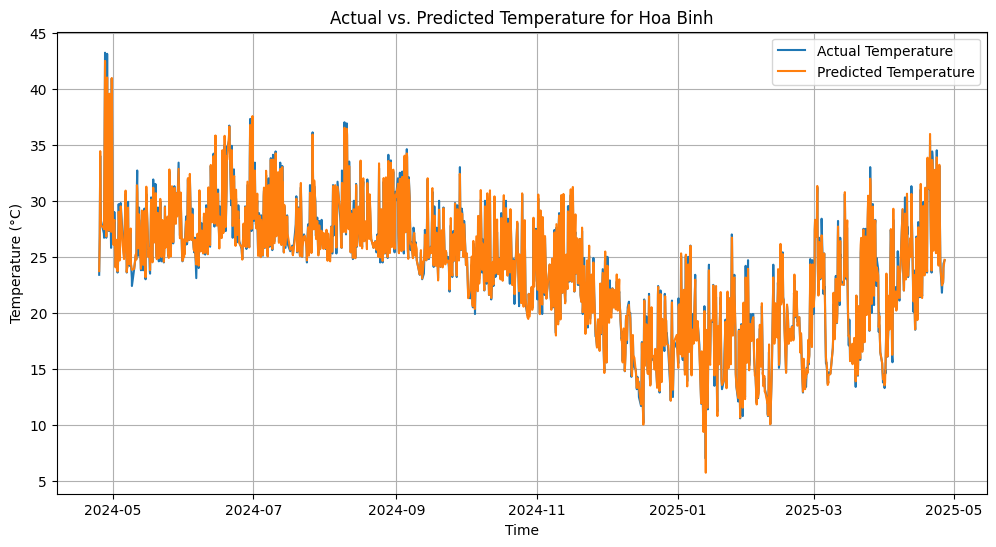

Visualizing predictions for Hoi An


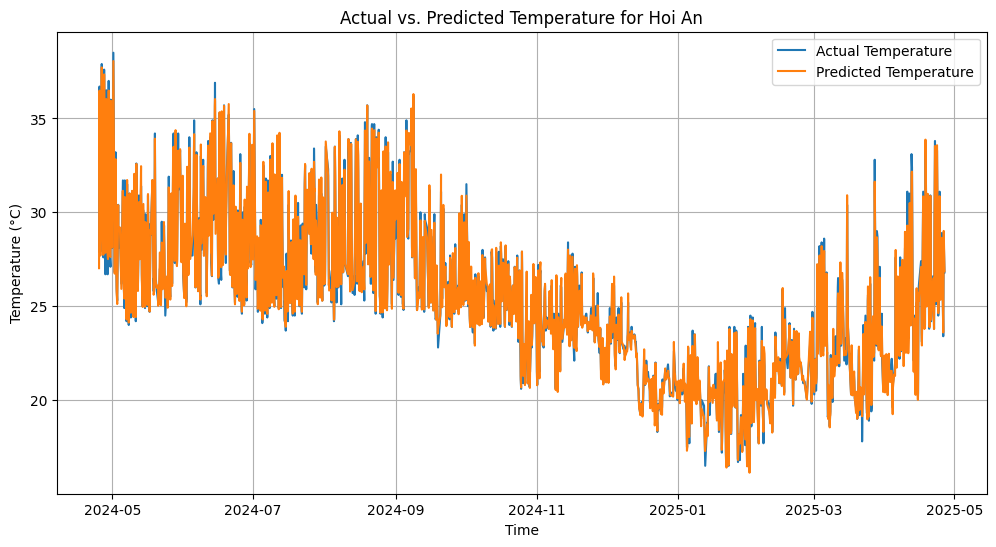

Visualizing predictions for Hong-Yen


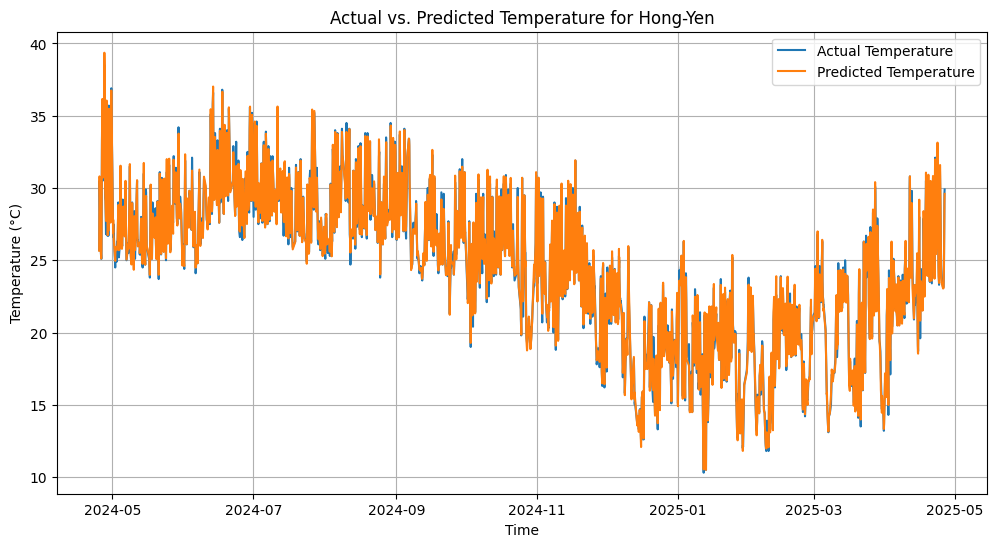

Visualizing predictions for Hue


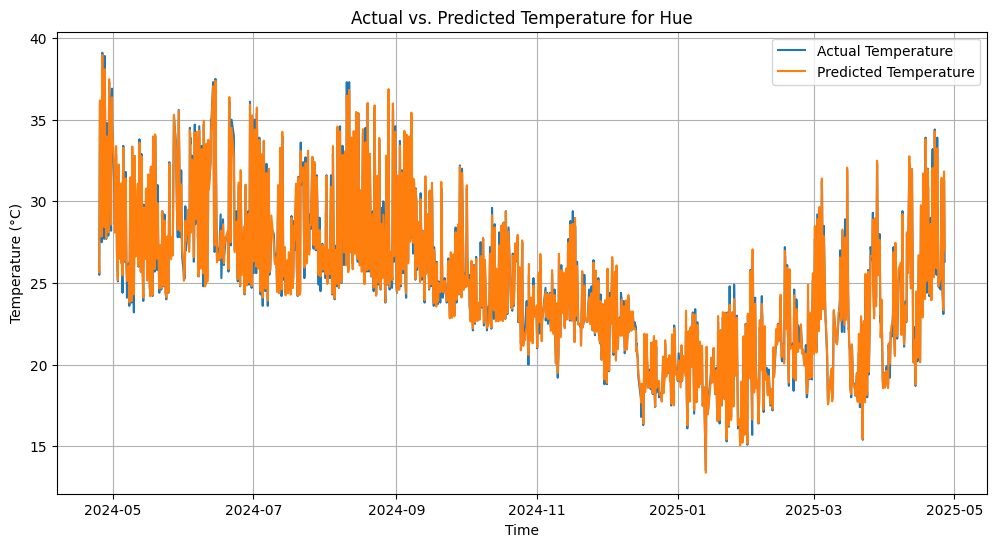

Visualizing predictions for Kon Tum


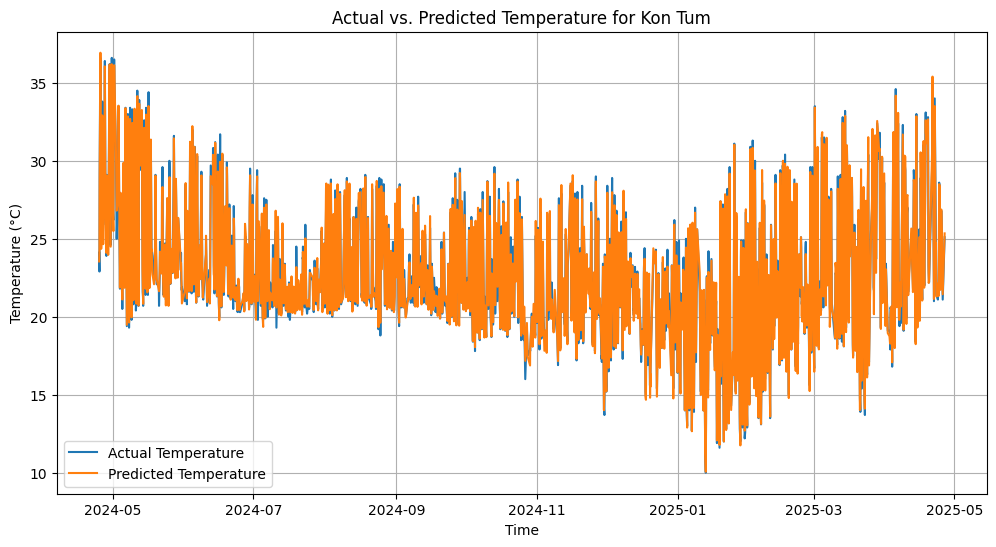

Visualizing predictions for Lao Cai


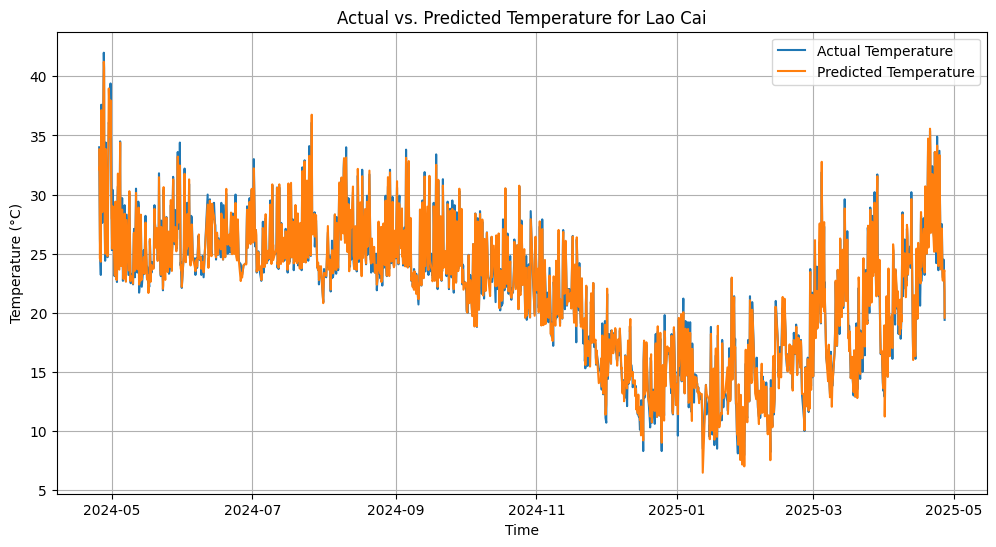

Visualizing predictions for Pa Nhie


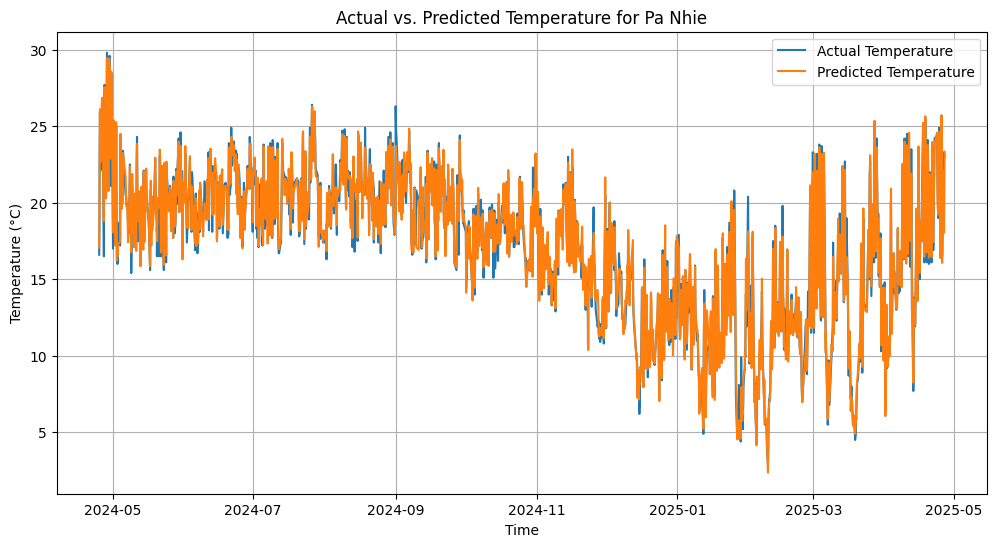

Visualizing predictions for Phan Thiet


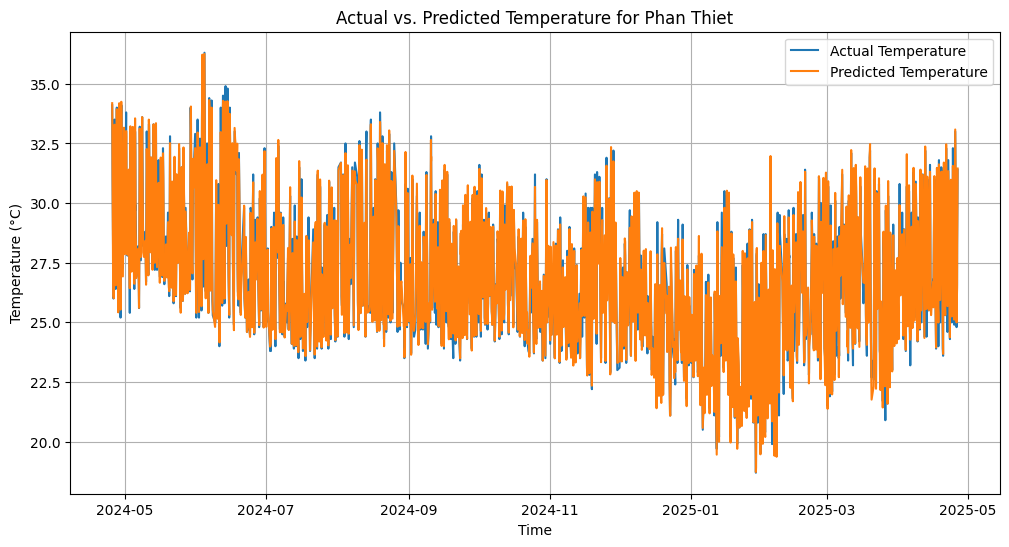

Visualizing predictions for Quang Ngai


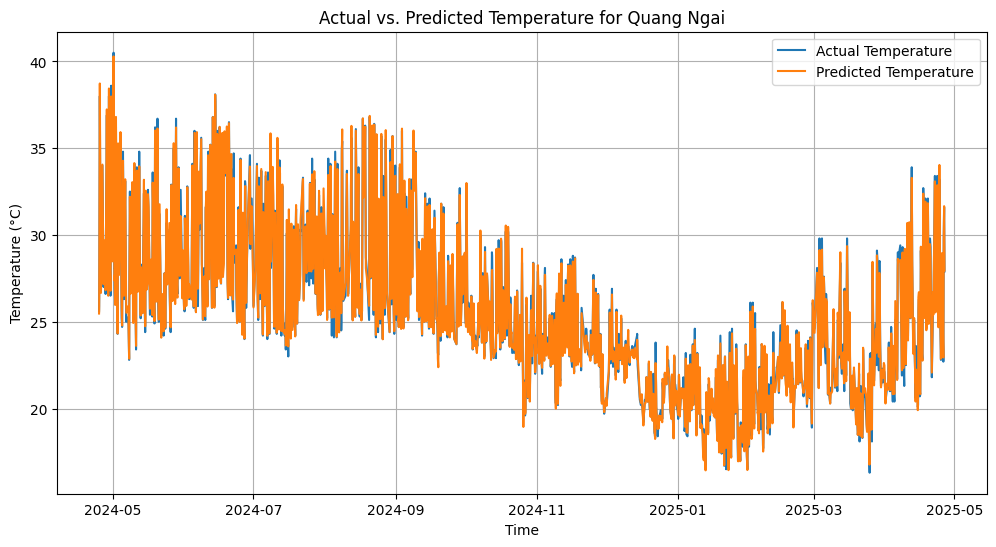

Visualizing predictions for Qui Nhon


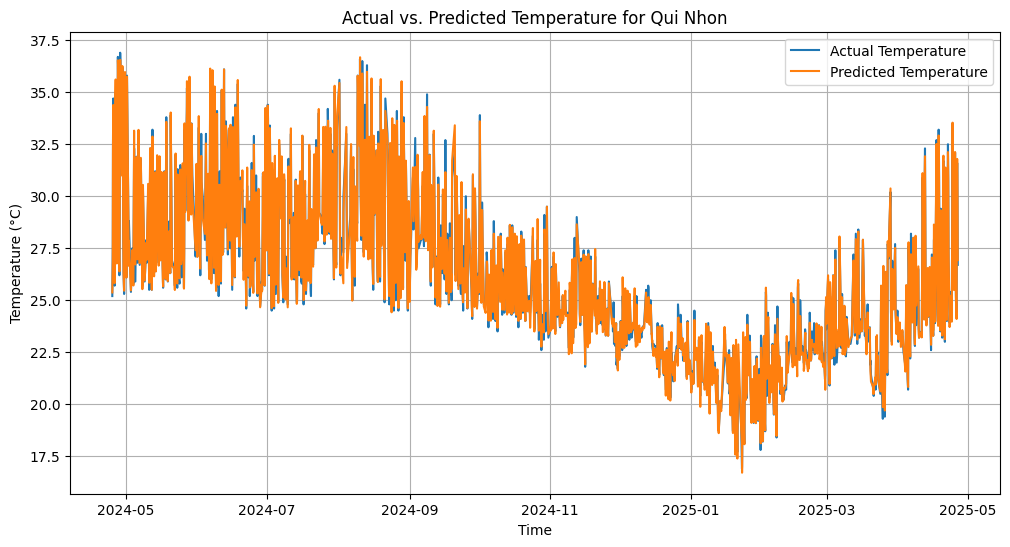

Visualizing predictions for Rach Gia


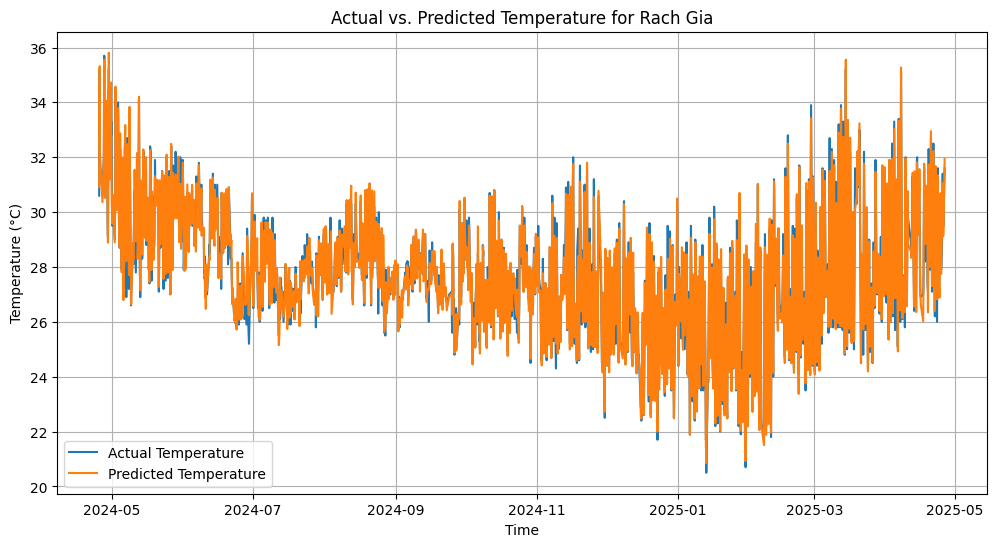

Visualizing predictions for Soc Trang


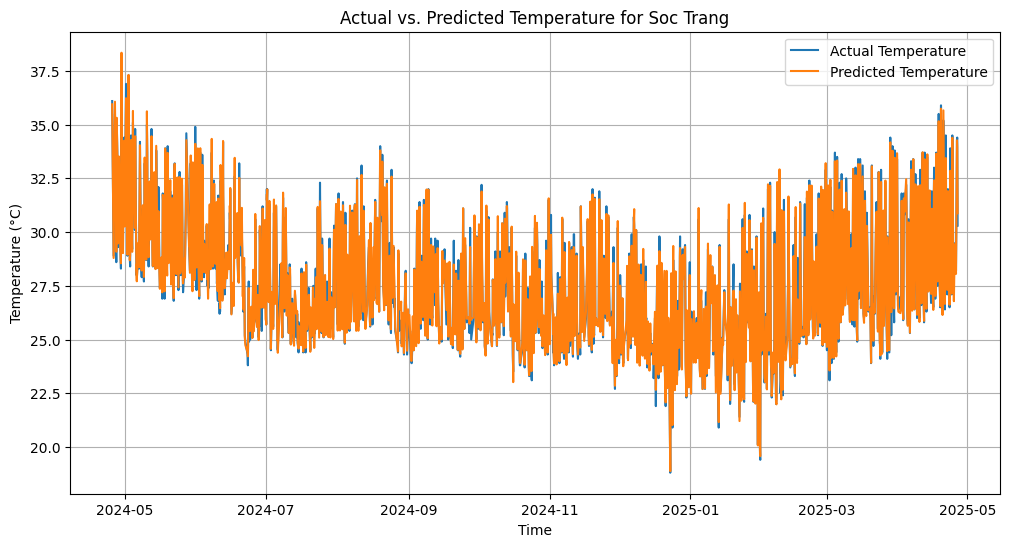

Visualizing predictions for Son La


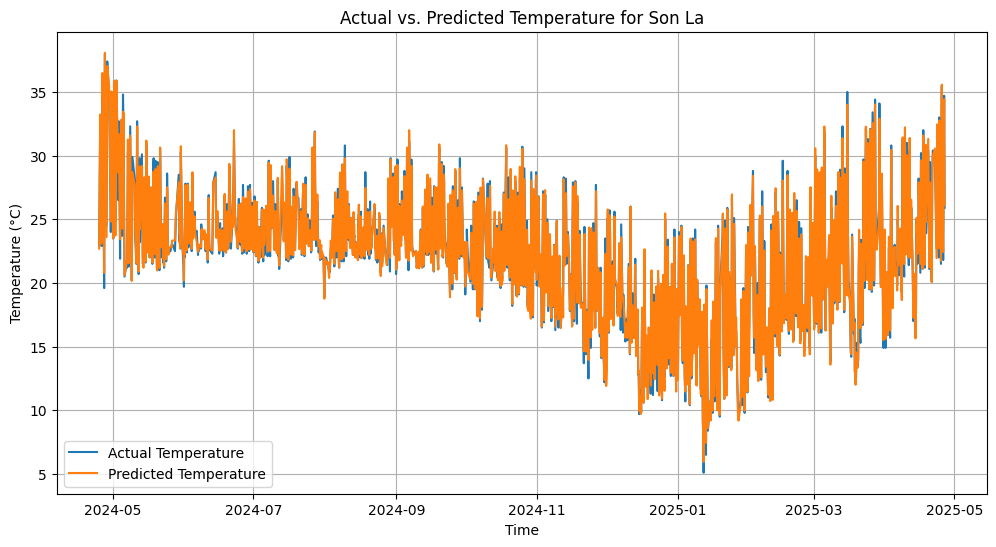

Visualizing predictions for Tan An


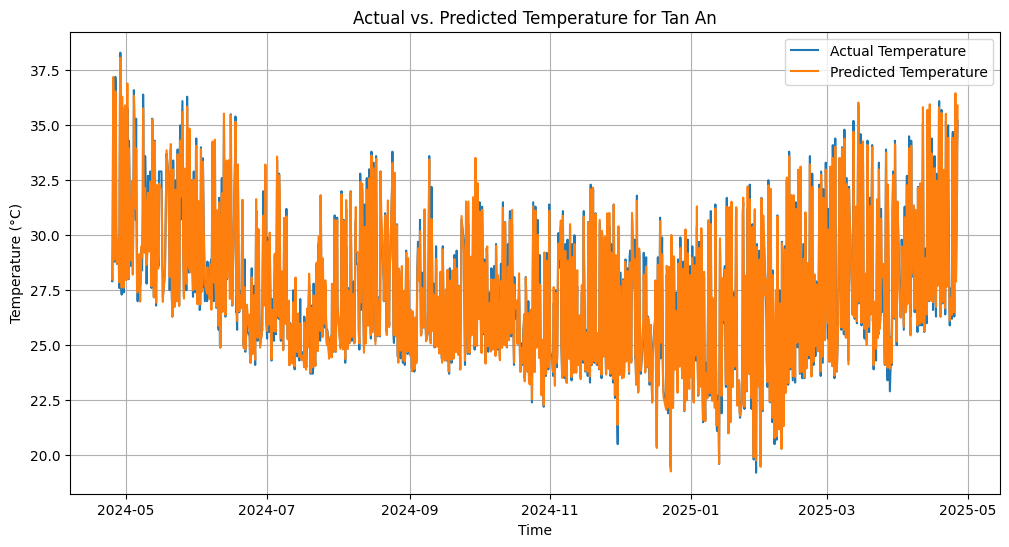

Visualizing predictions for Thanh Hoa


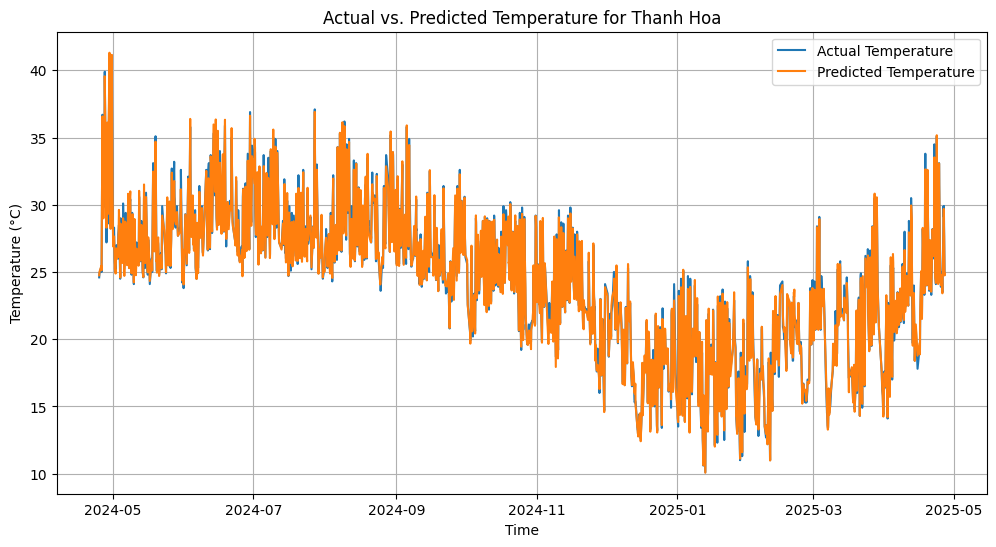

Visualizing predictions for Thanh Loi


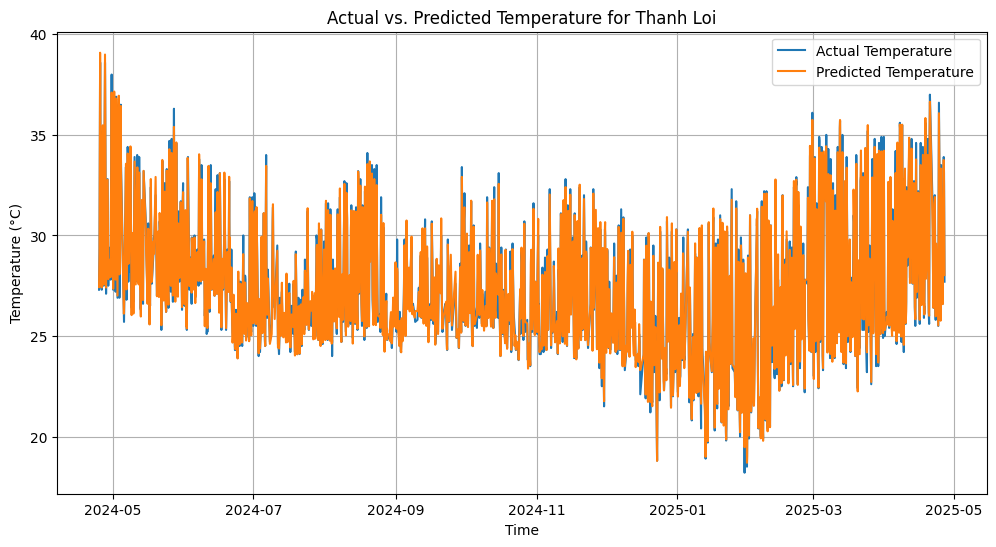

Visualizing predictions for Thon Nhu Le


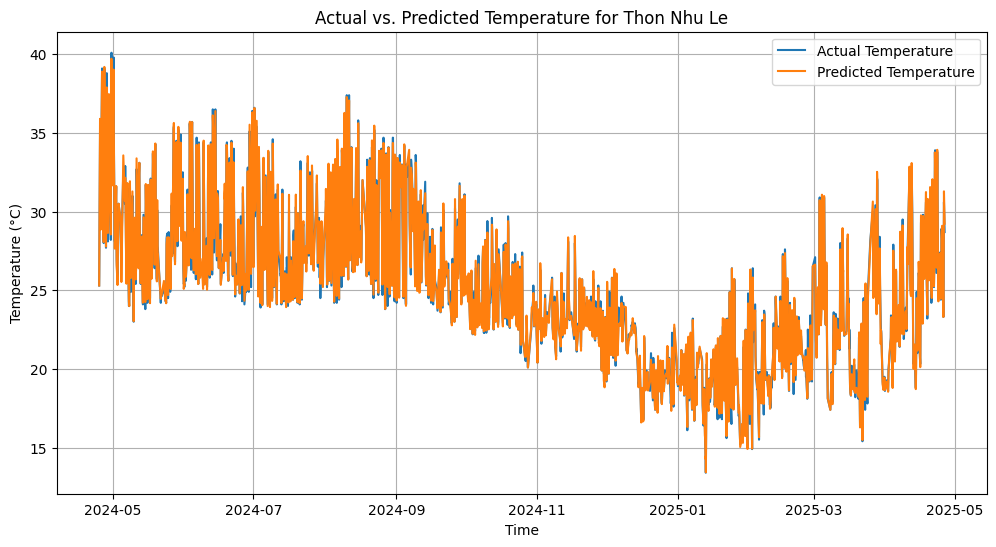

Visualizing predictions for Tra Vinh


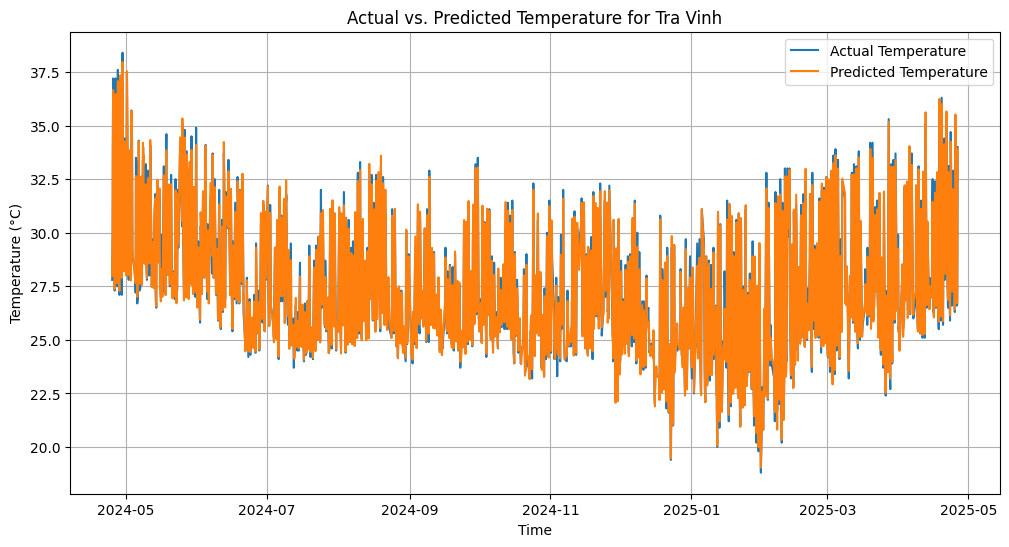

Visualizing predictions for Tu Xoay


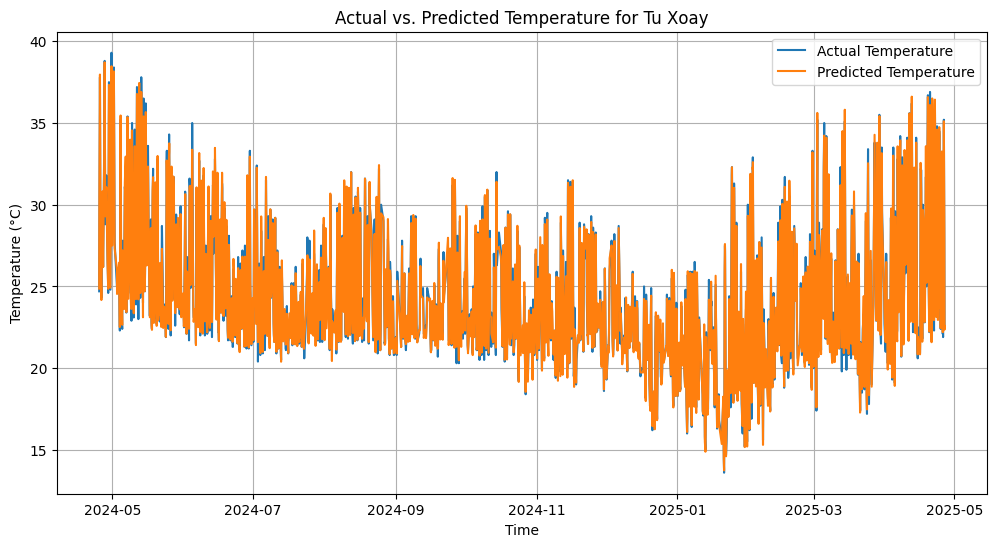

Visualizing predictions for Viet Tri


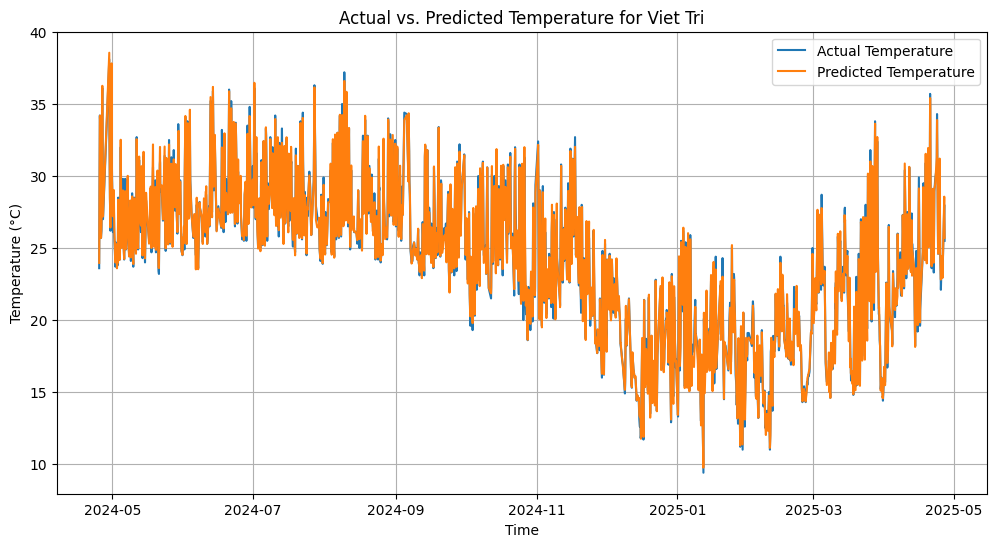

Visualizing predictions for Vinh


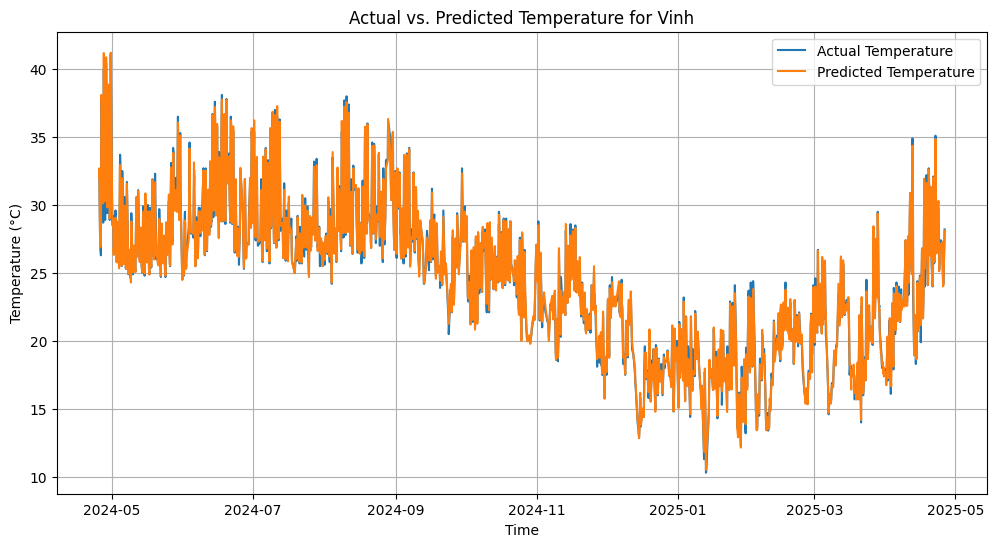

Visualizing predictions for Vinh Yen


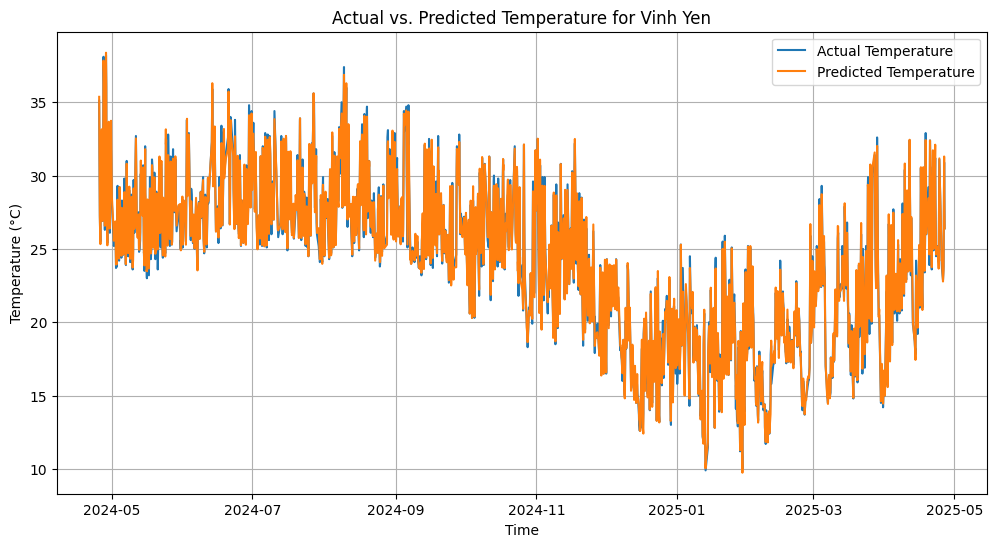

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

locations = df_temp.select("location_name").distinct().rdd.flatMap(lambda x: x).collect()

for location in locations:
    print(f"Visualizing predictions for {location}")
    test_df_location = test_df_gbt.filter(col("location_name") == location).sort("time")

    predictions_gbt_location = model_gbt.transform(test_df_location)

    predictions_pandas = predictions_gbt_location.select("time", "temp_c", "prediction").toPandas()
    predictions_pandas['time'] = pd.to_datetime(predictions_pandas['time'])

    plt.figure(figsize=(12, 6))
    plt.plot(predictions_pandas['time'], predictions_pandas['temp_c'], label='Actual Temperature')
    plt.plot(predictions_pandas['time'], predictions_pandas['prediction'], label='Predicted Temperature')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Actual vs. Predicted Temperature for {location}')
    plt.legend()
    plt.grid(True)
    plt.show()


# Dataset dự đoán nắng mưa

## Kiểm tra số lượng giá trị nắng mưa

In [ ]:
import matplotlib.pyplot as plt

will_it_rain_counts = df.groupBy("will_it_rain").count().toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x="will_it_rain", y="count", data=will_it_rain_counts)
plt.title("Count of 'will_it_rain' values")
plt.xlabel("Will it rain?")
plt.ylabel("Count")
plt.show()


In [ ]:
df_rain = df['location_name',
 'location',
 'time',
 'temp_c',
 'is_day',
 'wind_mph',
 'wind_degree',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain',
 'chance_of_rain',
 'condition',
 'wind_direct']

## Chia tập train, test

In [ ]:
from pyspark.sql.functions import rand

train_df_rain, test_df_rain, val_df_rain = df_rain.randomSplit([0.7, 0.2, 0.1], seed=42)

print(f"Train set size: {train_df_rain.count()}")
print(f"Test set size: {test_df_rain.count()}")
print(f"Validation set size: {val_df_rain.count()}")

## Stardard Scale (optional)

Fit scaler trên tập train, và transform scaler đó trên cả tập train và test.
Nếu mô hình cần dùng scale thì mới chạy đoạn code này.

In [ ]:
numeric_cols_rain = ['temp_c', 'is_day', 'wind_mph', 'wind_degree', 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'windchill_c', 'heatindex_c', 'dewpoint_c', 'vis_km', 'uv', 'gust_mph']

assembler_rain = VectorAssembler(inputCols=numeric_cols_rain, outputCol="features")
train_df_rain_assembled = assembler_rain.transform(train_df_rain)

scaler_rain = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model_rain = scaler_rain.fit(train_df_rain_assembled)

train_df_rain_scaled = scaler_model_rain.transform(train_df_rain_assembled)
test_df_rain_assembled = assembler_rain.transform(test_df_rain)
test_df_rain_scaled = scaler_model_rain.transform(test_df_rain_assembled)

train_df_rain_scaled.select("features", "scaled_features").show(5)
test_df_rain_scaled.select("features", "scaled_features").show(5)
